In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# ML
from sklearn.metrics import classification_report, confusion_matrix
from errors import MAE

# Atoms
from ase.io import read

# Utilities
import h5py
import json
import project_utils as utils

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


# TODO: turn plotting and classification stats into functions

# TODO: Make an argument to the functions to do the dummy DEEM classification

# TODO: Make an argument to the functions to do the full DEEM 330k classification

# Analysis setup

In [2]:
# Load SOAP cutoffs
with open('../../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [3]:
# Load train and test indices
idxs_deem_train = np.loadtxt('../../Processed_Data/DEEM_10k/train.idxs', dtype=int)
idxs_deem_test = np.loadtxt('../../Processed_Data/DEEM_10k/test.idxs', dtype=int)

n_deem_train = idxs_deem_train.size
n_deem_test = idxs_deem_test.size
n_deem = n_deem_train + n_deem_test

In [4]:
idxs_iza_train = np.loadtxt('../../Processed_Data/IZA_226/train.idxs', dtype=int)
idxs_iza_test = np.loadtxt('../../Processed_Data/IZA_226/test.idxs', dtype=int)

In [35]:
# Load indices of DEEM 10k set in 330k
idxs_deem_10k = np.loadtxt('../../Processed_Data/DEEM_330konDEEM_10k/deem_10k.idxs', dtype=int)

In [5]:
# Load IZA cantons
cantons_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]
cantons_iza = np.delete(cantons_iza, RWY)
n_iza = len(cantons_iza)

In [6]:
# Make dummy DEEM cantons
cantons_deem = np.ones(n_deem, dtype=int) * 4

In [7]:
# Build set of "master" canton labels
# TODO: make compatible with both 10k and 330k and don't hard code 330k number
cantons_train = {}
cantons_test = {}

cantons_train[4] = np.concatenate((cantons_iza[idxs_iza_train], cantons_deem[idxs_deem_train]))
#cantons_test[4] = np.concatenate((cantons_iza[idxs_iza_test], cantons_deem[idxs_deem_test]))
cantons_test[4] = np.concatenate((cantons_iza[idxs_iza_test], np.ones(331172, dtype=int) * 4)) ###

cantons_train[2] = np.concatenate((np.ones(len(idxs_iza_train), dtype=int),
                                   np.ones(len(idxs_deem_train), dtype=int) * 2))
#cantons_test[2] = np.concatenate((np.ones(len(idxs_iza_test), dtype=int),
#                                  np.ones(len(idxs_deem_test), dtype=int) * 2))
cantons_test[2] = np.concatenate((np.ones(len(idxs_iza_test), dtype=int),
                                  np.ones(331172, dtype=int) * 2)) ###

In [8]:
# Load dummy Deem cantons to test the "null" case -- i.e., the SVC shouldn't be able to classify
# a random splitting of DEEM
dummy_cantons_deem_2 = np.loadtxt('../../Processed_Data/DEEM_10k/dummy_cantons_2-class.dat')
dummy_cantons_deem_4 = np.loadtxt('../../Processed_Data/DEEM_10k/dummy_cantons_4-class.dat')
    
dummy_cantons_deem_train = {2: dummy_cantons_deem_2[idxs_deem_train],
                            4: dummy_cantons_deem_4[idxs_deem_train]}
dummy_cantons_deem_test = {2: dummy_cantons_deem_2[idxs_deem_test],
                           4: dummy_cantons_deem_4[idxs_deem_test]}

In [9]:
class_names = {}
class_names[2] = ['IZA', 'DEEM']
class_names[4] = ['IZA1', 'IZA2', 'IZA3', 'DEEM']

In [10]:
ticklabels = {2: ['IZA', 'DEEM'],
              4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']}
#ticklabels = {2: ['DEEM1', 'DEEM2'],
#              4: ['DEEM1', 'DEEM2', 'DEEM3', 'DEEM4']}

# Kernel Models

In [11]:
deem_name = 'DEEM_10k'
iza_name = 'IZA_226onDEEM_10k'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

## Plotting

===== 3.5 | Linear | 4-Class =====


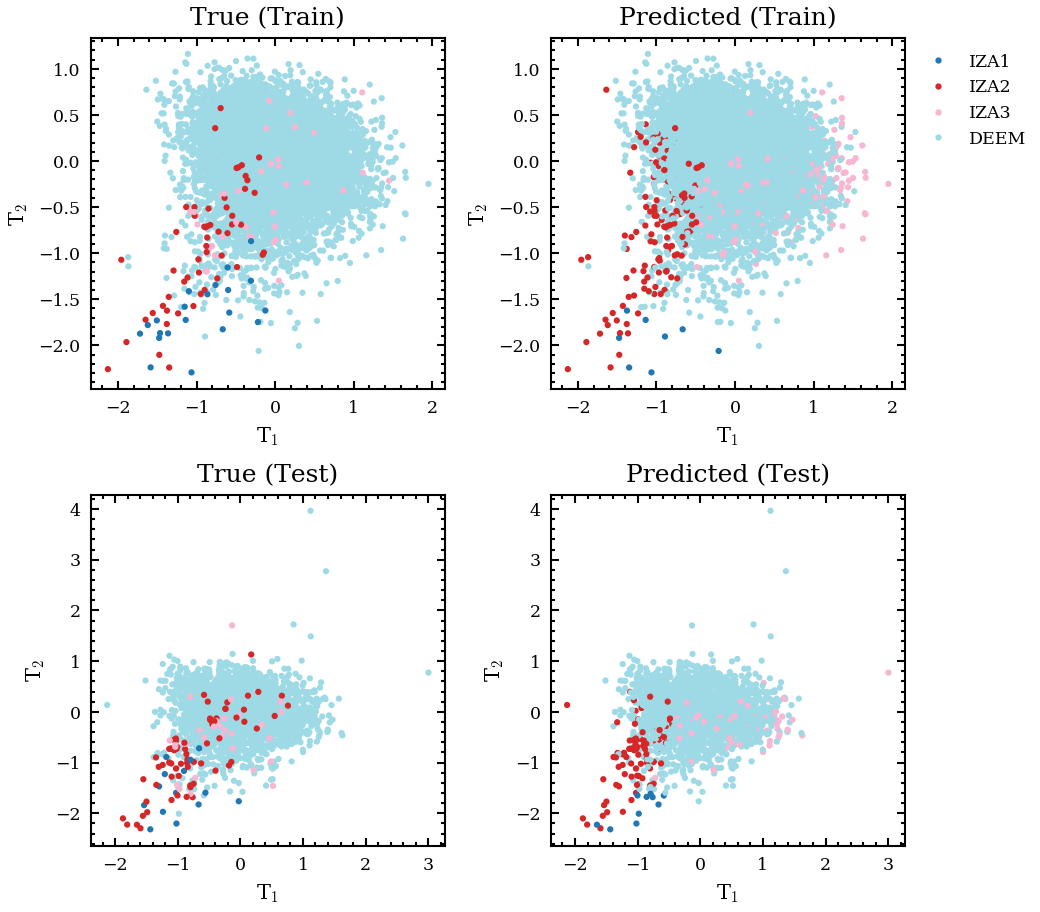

===== 3.5 | Gaussian | 4-Class =====


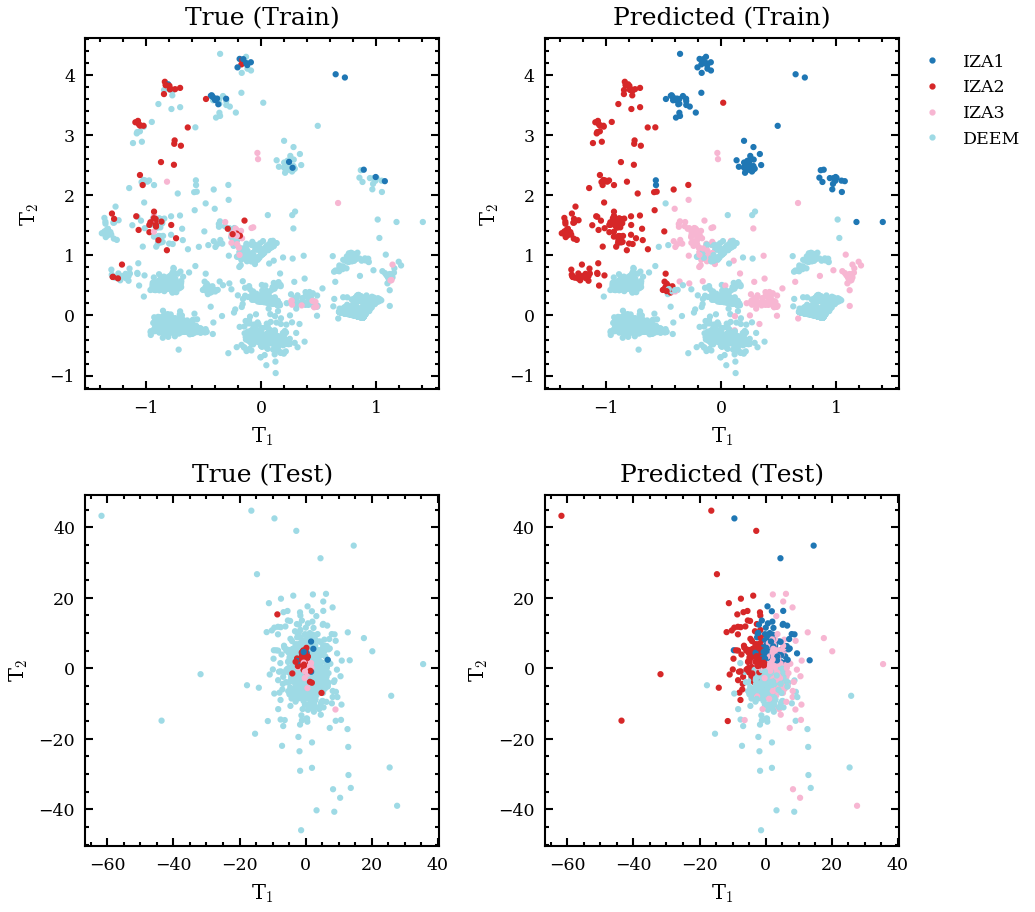

===== 6.0 | Linear | 4-Class =====


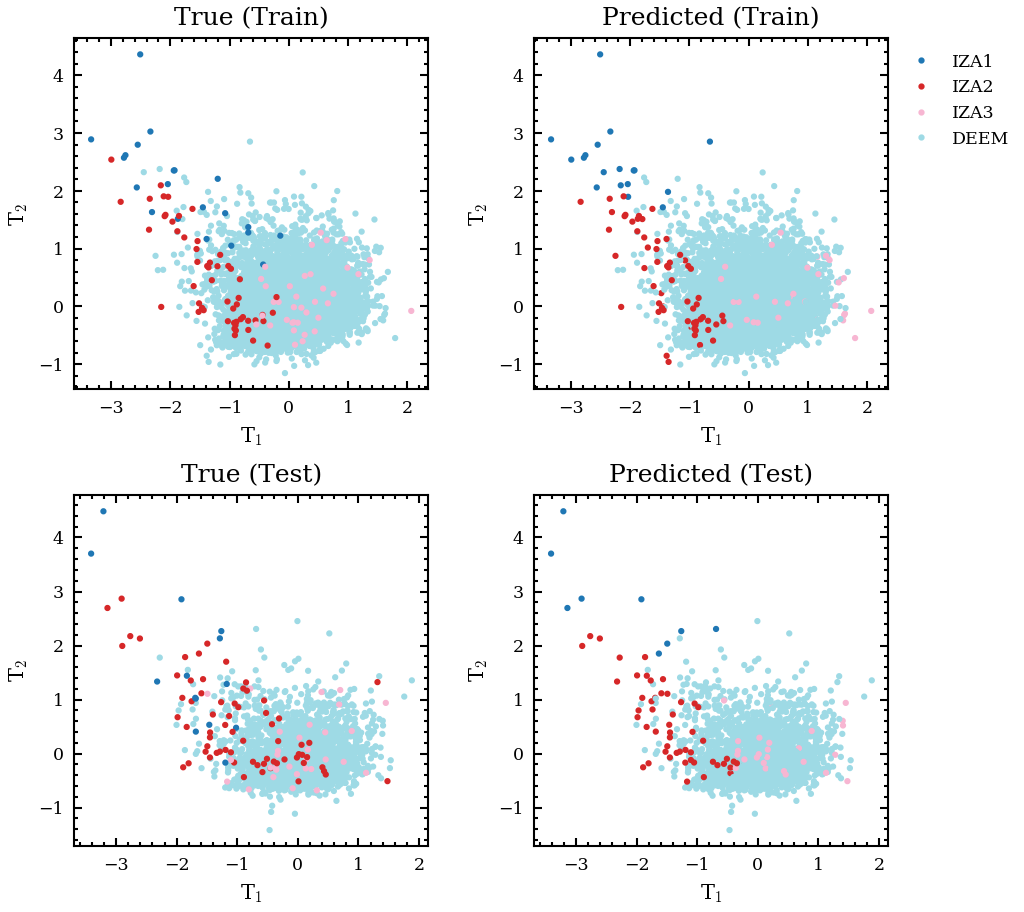

===== 6.0 | Gaussian | 4-Class =====


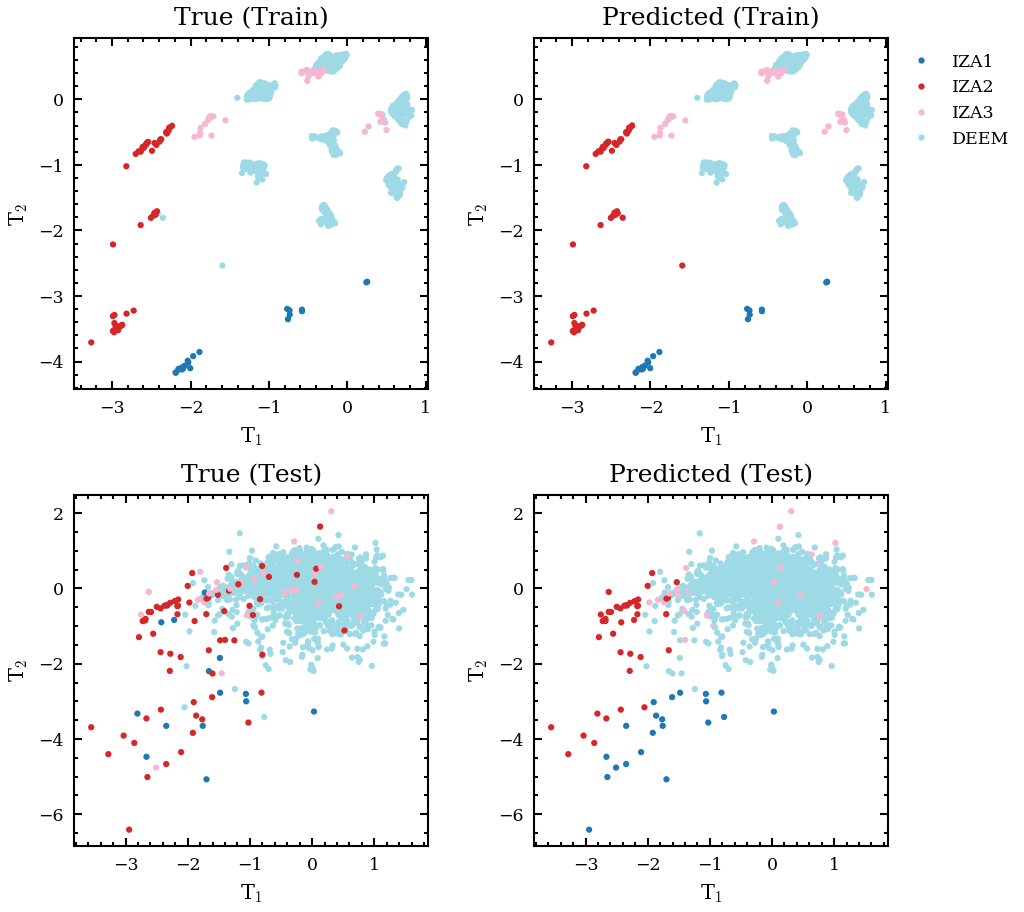

In [14]:
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        for n_cantons in [4]: #(2, 4):
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'
            output_dir = f'../../Results/{cutoff}/Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'
            
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            
            print(f'===== {cutoff} | {kernel_name} | {n_cantons}-Class =====')
    
            # Load projections
            deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
            T_deem = utils.load_structures_from_hdf5(deem_file, datasets=None, concatenate=True)

            iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
            T_iza = utils.load_structures_from_hdf5(iza_file, datasets=None, concatenate=True)

            # Load predicted cantons
            deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
            predicted_cantons_deem = np.loadtxt(deem_file, dtype=int)

            iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
            predicted_cantons_iza = np.loadtxt(iza_file, dtype=int)

            fig = plt.figure(figsize=(7.0, 7.0))
            axs_true_train = fig.add_subplot(2, 2, 1)
            axs_predicted_train = fig.add_subplot(2, 2, 2)
            axs_true_test = fig.add_subplot(2, 2, 3)
            axs_predicted_test = fig.add_subplot(2, 2, 4)
            scatter_opts = dict(cmap='tab20', vmin=1, vmax=4)
            df_idx = 0

            axs_true_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                        c=cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
            axs_true_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                        c=cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

            axs_predicted_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                        #c=df_deem_train[:, df_idx])
                        c=predicted_cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
            axs_predicted_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                        #c=df_iza_train[:, df_idx])
                        c=predicted_cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

            axs_true_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
                    c=cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
            axs_true_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                    c=cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

            axs_predicted_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
                    #c=df_deem_test[:, df_idx])
                    c=predicted_cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
            axs_predicted_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                    #c=df_iza_test[:, df_idx])
                    c=predicted_cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

            handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
                       Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
                       Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
                       Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]

            labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
            axs_predicted_train.legend(handles=handles, labels=labels, 
                                       loc='upper left', bbox_to_anchor=(1.0, 1.0))

            for ax in (axs_true_train, axs_predicted_train, axs_true_test, axs_predicted_test):
                ax.set_xlabel(r'T$_1$')
                ax.set_ylabel(r'T$_2$')

            axs_true_train.set_title('True (Train)')
            axs_predicted_train.set_title('Predicted (Train)')
            axs_true_test.set_title('True (Test)')
            axs_predicted_test.set_title('Predicted (Test)')

            fig.subplots_adjust(wspace=0.3, hspace=0.3)

            fig.savefig(f'{output_dir}/svm-kpcovr.png', bbox_inches='tight')

            plt.show()

## Classification statistics

### KernelSVC

In [13]:
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        for n_cantons in (2, 4):
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'
            
            print(f'===== {cutoff} | {kernel_name} | {n_cantons}-Class =====')
            
            predicted_cantons_iza = \
                np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
            predicted_cantons_deem = \
                np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

            predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                      predicted_cantons_deem[idxs_deem_train]))
            predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                     predicted_cantons_deem[idxs_deem_test]))

            matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
            matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)
            
            print('----- Train -----')
            print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                        zero_division=0))
            print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
            print()
            print(matrix_train)
            print()

            print('----- Test -----')
            print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                        zero_division=0))
            print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
            print()
            print(matrix_test)
            print()

===== 3.5 | Linear | 2-Class =====


ValueError: Found input variables with inconsistent numbers of samples: [331285, 2363]

In [ ]:
fig_2class = plt.figure(figsize=(4.5, 3.5), constrained_layout=True)
fig_4class = plt.figure(figsize=(4.5, 3.5), constrained_layout=True)

n_rows = 2
n_cols = 2

vmin = 0.0 #-len(idxs_iza_test)
vmax = 1.0 #len(idxs_iza_test)

width_ratios = np.ones(n_cols + 1)
width_ratios[-1] = 0.25

for fig, n_cantons in zip((fig_2class, fig_4class), (2, 4)):
    gs = fig.add_gridspec(nrows=n_rows, ncols=n_cols+1, 
                          width_ratios=width_ratios,
                          hspace=0.05, wspace=0.05)
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(0, n_cols)] for i in range(0, n_rows)])
    row_idx = 0
    for cutoff in cutoffs:
        col_idx = 0
        for kernel_type in ('linear', 'gaussian'):
            kernel_name = kernel_type.capitalize()

            # Prepare outputs
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'

#             predicted_cantons_iza = \
#                 np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
#             predicted_cantons_deem = \
#                 np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

#             predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
#                                                       predicted_cantons_deem[idxs_deem_train]))
#             predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
#                                                      predicted_cantons_deem[idxs_deem_test]))

            dummy_cantons = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/dummy_svc_structure_cantons.dat', dtype=int) ###
            predicted_cantons_train = dummy_cantons[idxs_deem_train] ###
            predicted_cantons_test = dummy_cantons[idxs_deem_test] ###
            
#             matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
#             matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)

            matrix_train = confusion_matrix(dummy_cantons_deem_train[n_cantons], predicted_cantons_train) ###
            matrix_test = confusion_matrix(dummy_cantons_deem_test[n_cantons], predicted_cantons_test) ###

            matrix_ref = np.zeros((n_cantons, n_cantons), dtype=int)

            for i in range(0, n_cantons):
                #matrix_ref[i, i] = np.count_nonzero(cantons_test[n_cantons] == (i + 1))
                matrix_ref[i, i] = np.count_nonzero(dummy_cantons_deem_test[n_cantons] == (i + 1)) ###

            matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]

            ax = axes[row_idx, col_idx]
            ax.imshow(matrix_norm, cmap='Reds', vmin=vmin, vmax=vmax)

            if n_cantons == 2:
                text_size = 'medium'
            else:
                text_size = 'xx-small'

            for i in range(0, n_cantons):
                for j in range(0, n_cantons):
                    if matrix_norm[i, j] > (0.5 * vmax):
                        text_color = 'w'
                    else:
                        text_color = 'k'
                    ax.text(j, i, f'{matrix_test[i, j]:d}', 
                            horizontalalignment='center', verticalalignment='center',
                            color=text_color, fontsize=text_size)

            ax.set_xticks(np.arange(0, n_cantons))
            ax.set_yticks(np.arange(0, n_cantons))

            ax.tick_params(axis='both', which='both', 
                           left=False, bottom=False, right=False, top=False,
                           labelleft=False, labelbottom=False, labelright=False, labeltop=False)

            if col_idx == 0:
                ax.set_ylabel(f'{cutoff} ' + u'\u00c5')
                ax.set_yticklabels(ticklabels[n_cantons])
                ax.tick_params(axis='y', which='both', labelleft=True)

            if row_idx == 0:
                ax.set_title(f'{kernel_name}', fontsize='medium')
            elif row_idx == (n_rows - 1):
                ax.set_xticklabels(ticklabels[n_cantons], rotation=90)
                ax.tick_params(axis='x', which='both', labelbottom=True)

            col_idx += 1
        
        row_idx += 1        
    
#     cp_xy = (0.5, 1.3)
#     cp_power_bar_frac = -0.02
#     cp_radial_bar_frac = cp_power_bar_frac * 3
#     cp_power = ConnectionPatch(xyA=cp_xy, coordsA=axes[0, 0].transAxes,
#                                xyB=cp_xy, coordsB=axes[0, 6].transAxes,
#                                connectionstyle=f'bar,fraction={cp_power_bar_frac}')
#     cp_radial = ConnectionPatch(xyA=cp_xy, coordsA=axes[0, 7].transAxes,
#                                 xyB=cp_xy, coordsB=axes[0, 9].transAxes,
#                                connectionstyle=f'bar,fraction={cp_radial_bar_frac}')
    
#     n_power = len(group_names['power'])
#     n_radial = len(group_names['radial'])
    
#     power_label_ax = axes[0, n_power // 2]
#     if n_power % 2 == 0:
#         power_shift = 0.5
#     else:
#         power_shift = 0.0
        
#     radial_label_ax = axes[0, n_radial // 2 + n_power]
#     if n_radial % 2 == 0:
#         radial_shift = 0.5
#     else:
#         radial_shift = 0.0
    
#     fig.text(0.5 - power_shift, 1.65, 'Power Spectrum',
#              horizontalalignment='center', verticalalignment='center',
#              transform=power_label_ax.transAxes, fontsize='large')
    
#     fig.text(0.5 - radial_shift, 1.65, 'Radial Spectrum',
#              horizontalalignment='center', verticalalignment='center',
#              transform=radial_label_ax.transAxes, fontsize='large')
    
    cax = fig.add_subplot(gs[:, -1])
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='Reds'), 
                      cax=cax)
    cb.set_label('True Class Proportion')
    
#     fig.add_artist(cp_power)
#     fig.add_artist(cp_radial)
    fig.suptitle(f'{n_cantons}-Class', y=1.1)
    
    #fig.savefig(f'../../Results/svc_confusion_matrices_{n_cantons}-class_kernel.pdf', bbox_inches='tight')
    fig.savefig(f'../../Results/dummy_svc_confusion_matrices_{n_cantons}-class_kernel.pdf', bbox_inches='tight')
    
plt.show()

### KPCovR

In [ ]:
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        for n_cantons in (2, 4):
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'
            
            print(f'===== {cutoff} | {kernel_type} | {n_cantons}-Class =====')
            
            predicted_cantons_iza = \
                np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)
            predicted_cantons_deem = \
                np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)

            predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                      predicted_cantons_deem[idxs_deem_train]))
            predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                     predicted_cantons_deem[idxs_deem_test]))

            dfs_svc_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
            dfs_svc_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

            dfs_pcovr_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')
            dfs_pcovr_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')

            dfs_svc_train = np.concatenate((dfs_svc_iza[idxs_iza_train],
                                            dfs_svc_deem[idxs_deem_train]))
            dfs_svc_test = np.concatenate((dfs_svc_iza[idxs_iza_test],
                                           dfs_svc_deem[idxs_deem_test]))

            dfs_pcovr_train = np.concatenate((dfs_pcovr_iza[idxs_iza_train],
                                              dfs_pcovr_deem[idxs_deem_train]))
            dfs_pcovr_test = np.concatenate((dfs_pcovr_iza[idxs_iza_test],
                                             dfs_pcovr_deem[idxs_deem_test]))

            matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
            matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)
            
            print('----- Train -----')
            print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                        zero_division=0))
            print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
            print()
            print(matrix_train)
            print()
            print('Train DF MAE:', MAE(dfs_svc_train, dfs_pcovr_train))
            print()

            print('----- Test -----')
            print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                        zero_division=0))
            print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
            print()
            print(matrix_test)
            print()
            print('Test DF MAE:', MAE(dfs_svc_test, dfs_pcovr_test))
            print()

# Linear Models

In [36]:
# Linear model setup
n_species = 2
group_names = {'power': ['OO', 'OSi', 'SiSi', 
                         'OO+OSi', 'OO+SiSi', 'OSi+SiSi',
                         'OO+OSi+SiSi'], 
               'radial': ['O', 'Si', 'O+Si']}

In [37]:
deem_name = 'DEEM_10k'
all_deem_name = 'DEEM_330k'
iza_name = 'IZA_226'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
all_deem_dir = f'../../Processed_Data/{all_deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

## Plotting

===== 3.5 | 4-Class | Power | OO =====


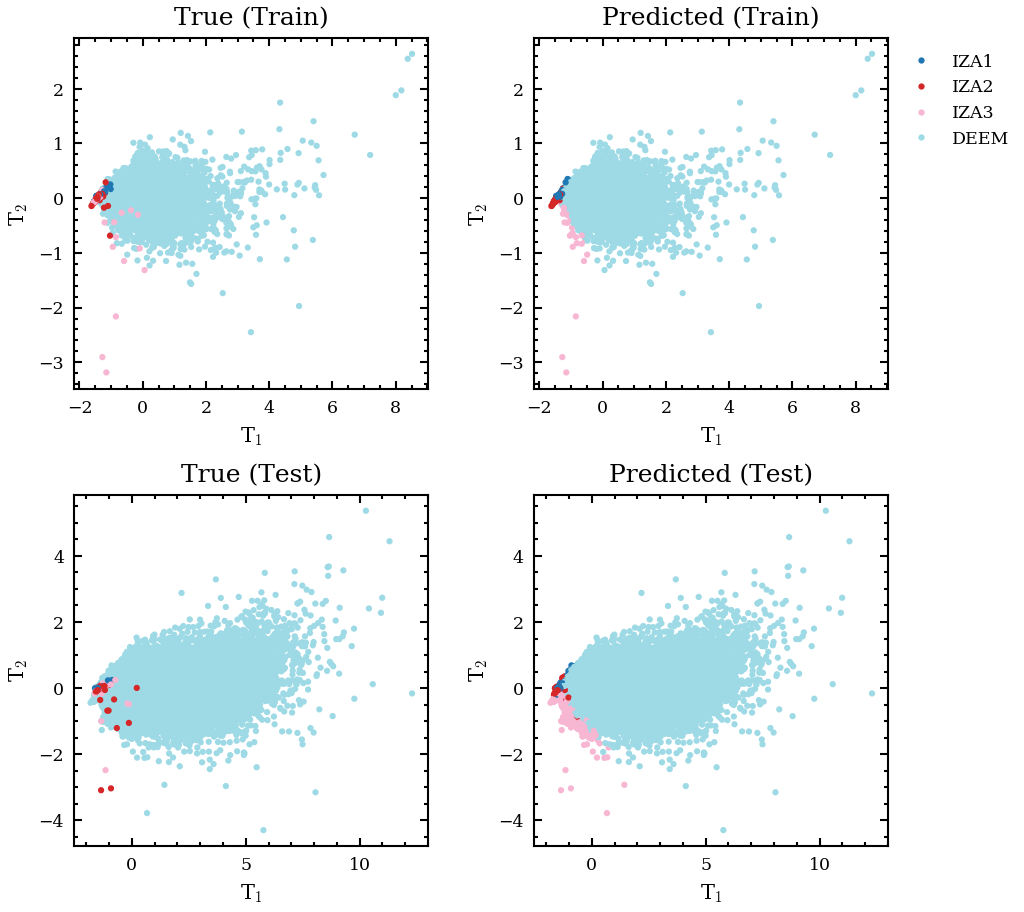

===== 3.5 | 4-Class | Power | OSi =====


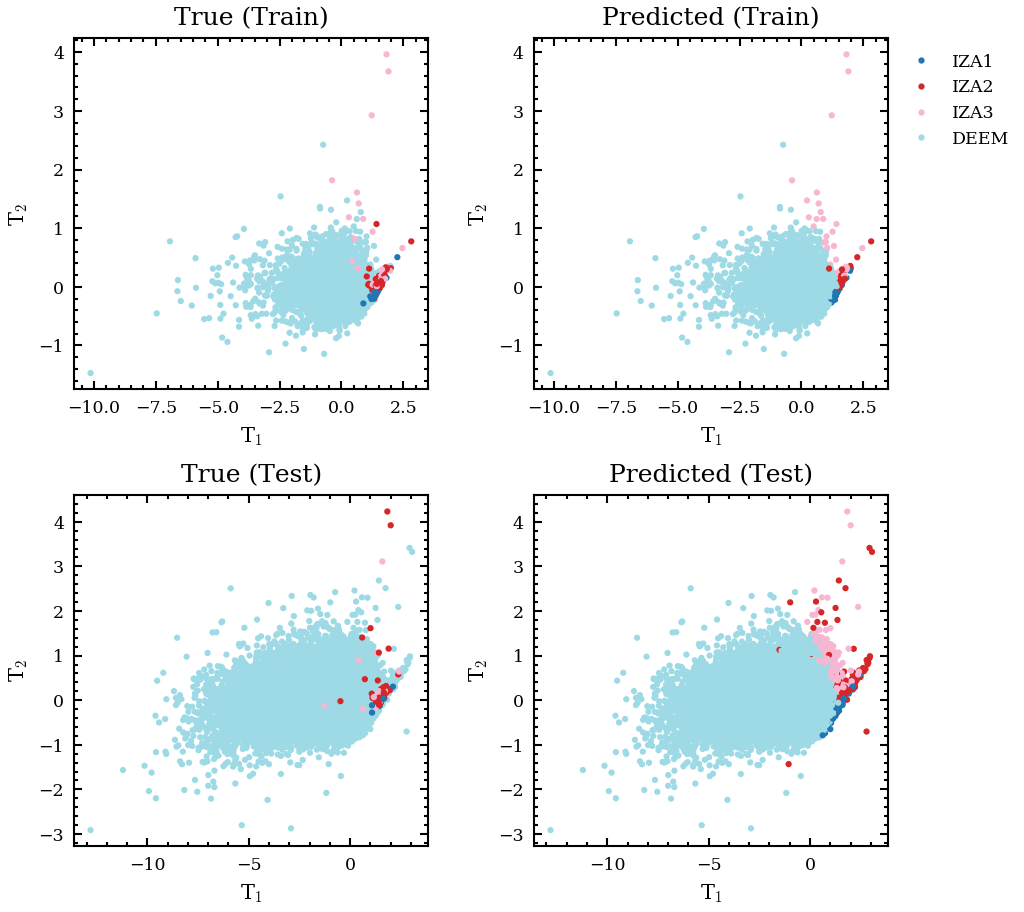

===== 3.5 | 4-Class | Power | SiSi =====


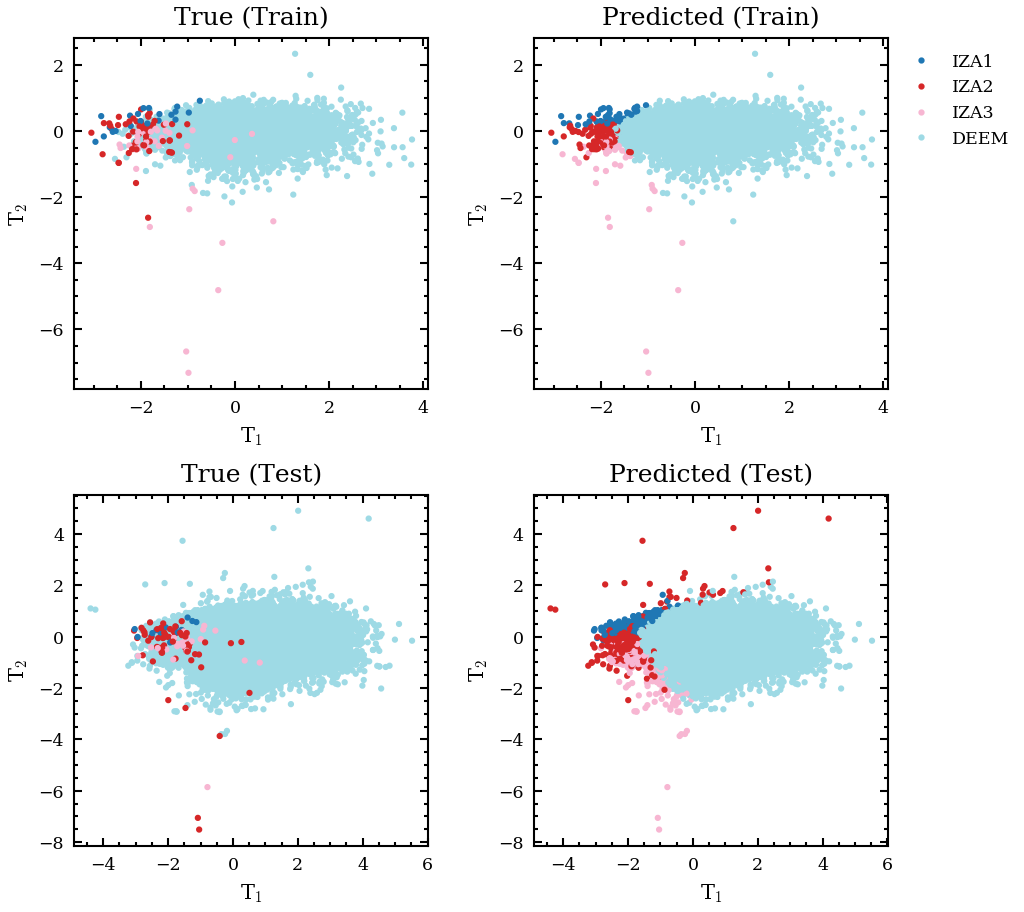

===== 3.5 | 4-Class | Power | OO+OSi =====


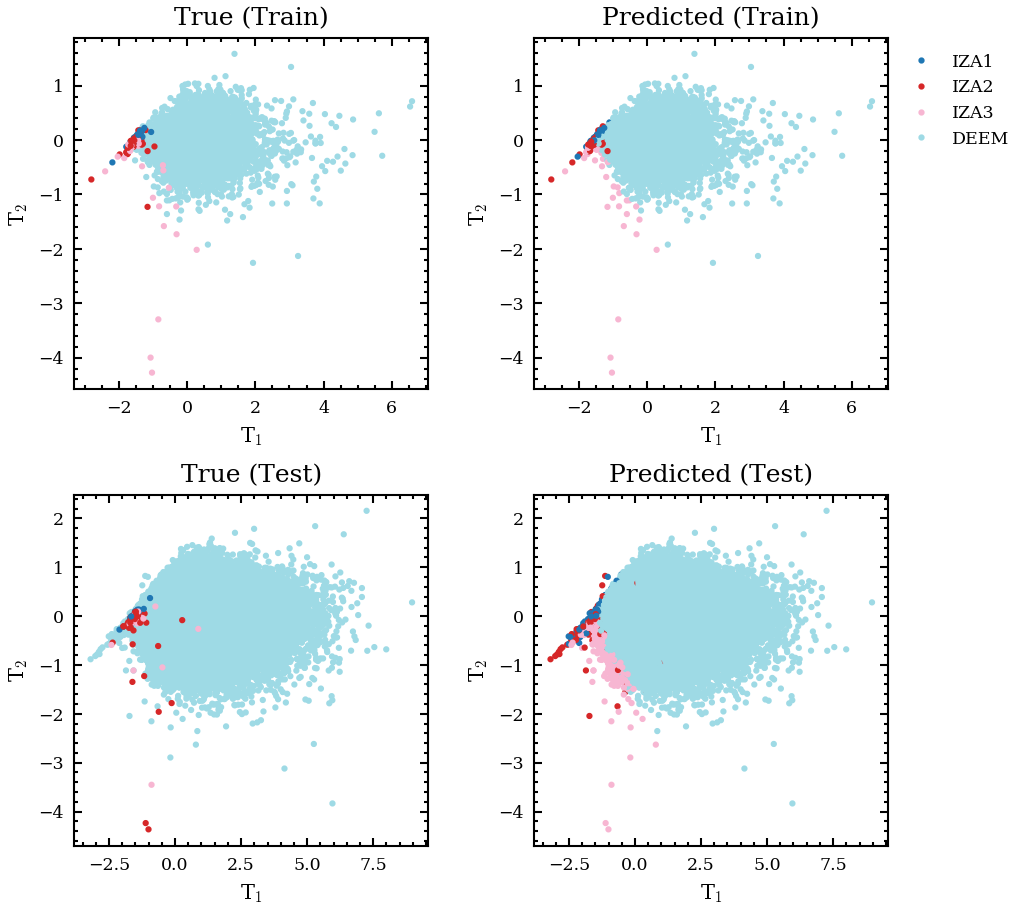

===== 3.5 | 4-Class | Power | OO+SiSi =====


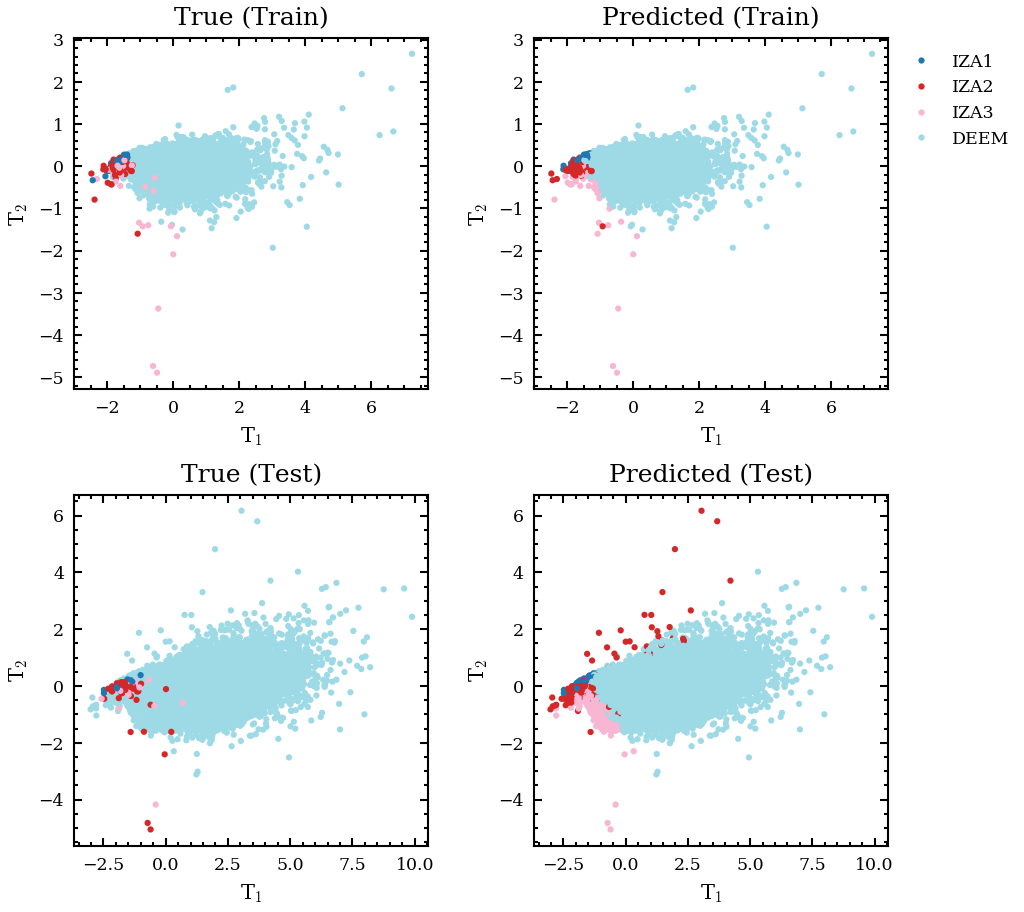

===== 3.5 | 4-Class | Power | OSi+SiSi =====


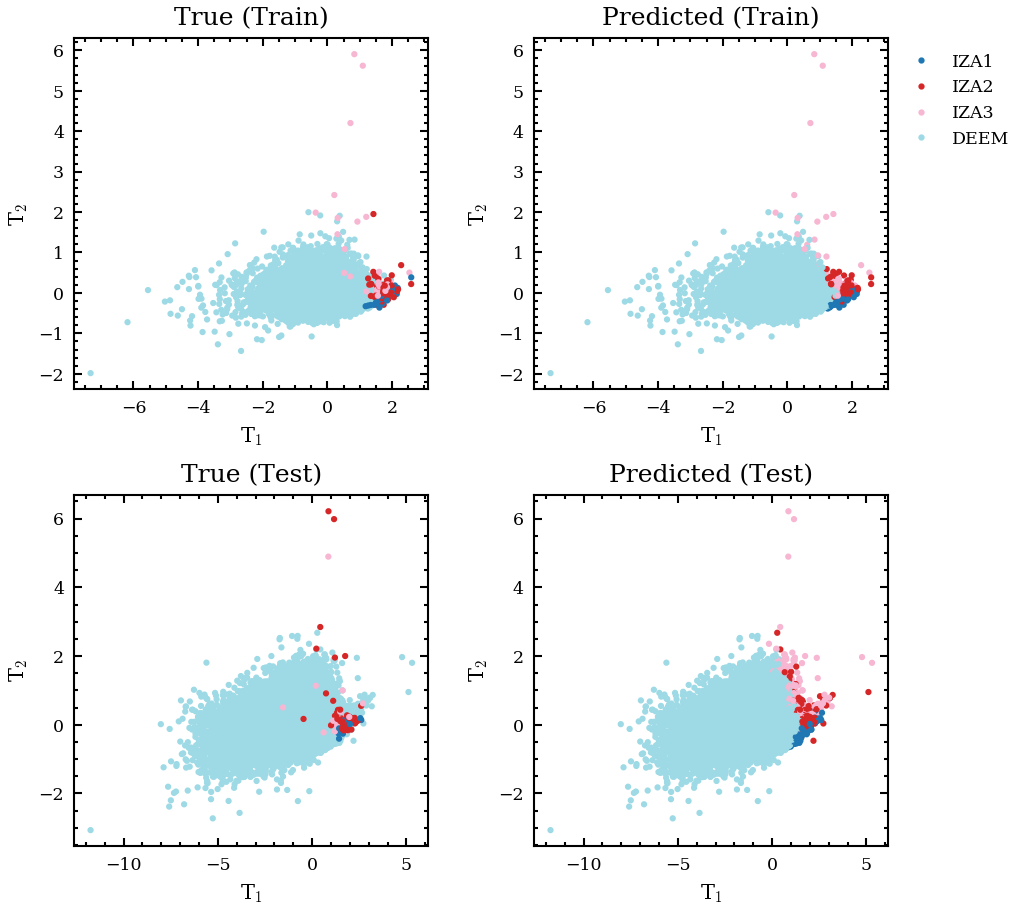

===== 3.5 | 4-Class | Power | OO+OSi+SiSi =====


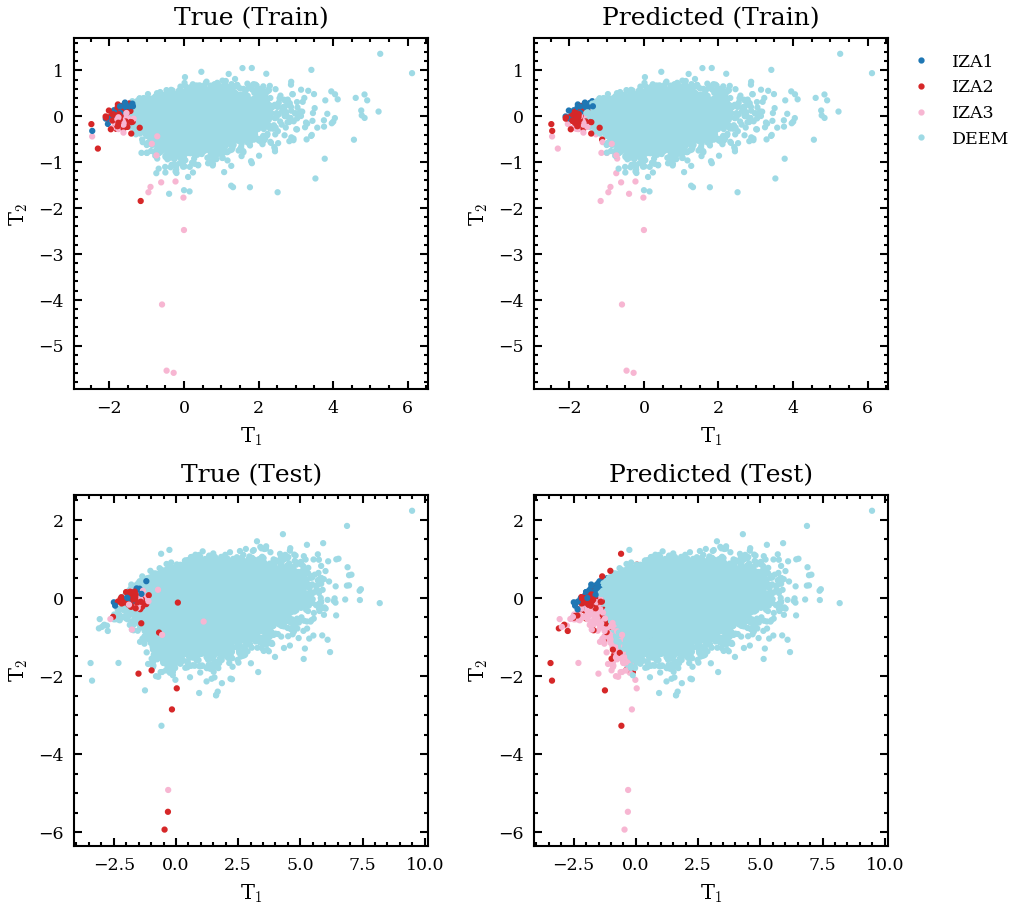

===== 3.5 | 4-Class | Radial | O =====


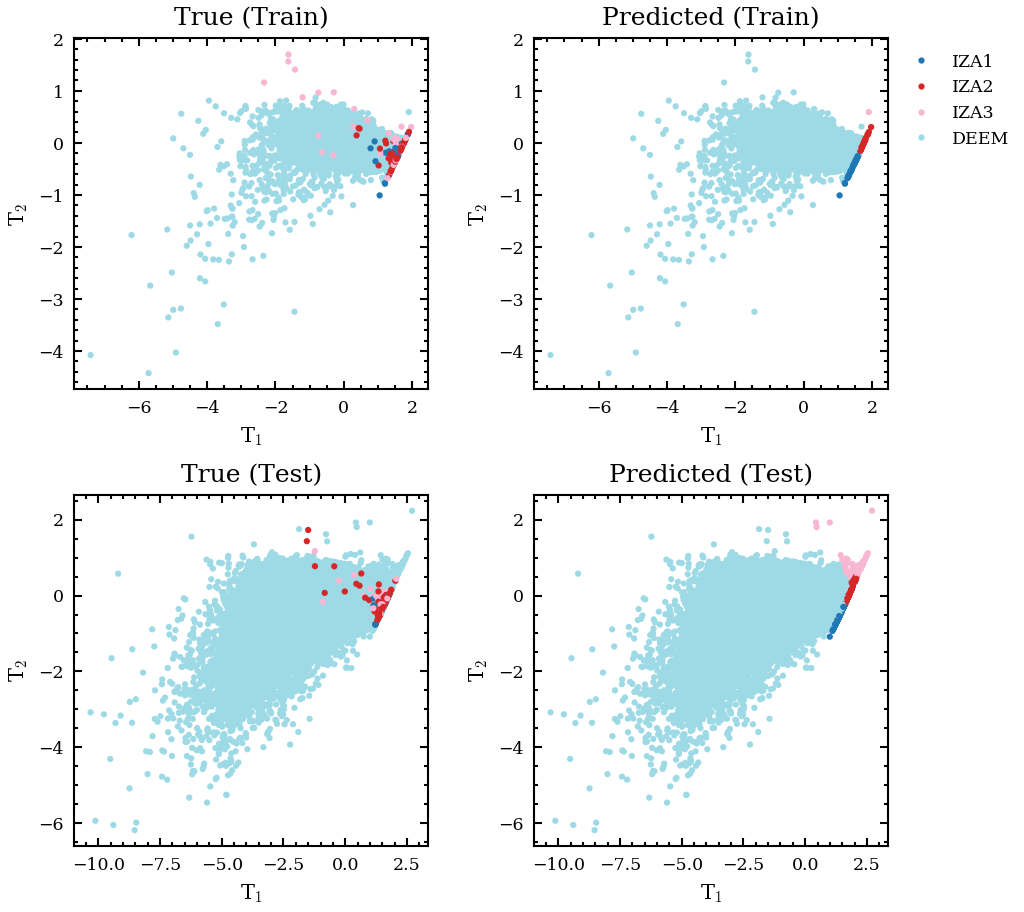

===== 3.5 | 4-Class | Radial | Si =====


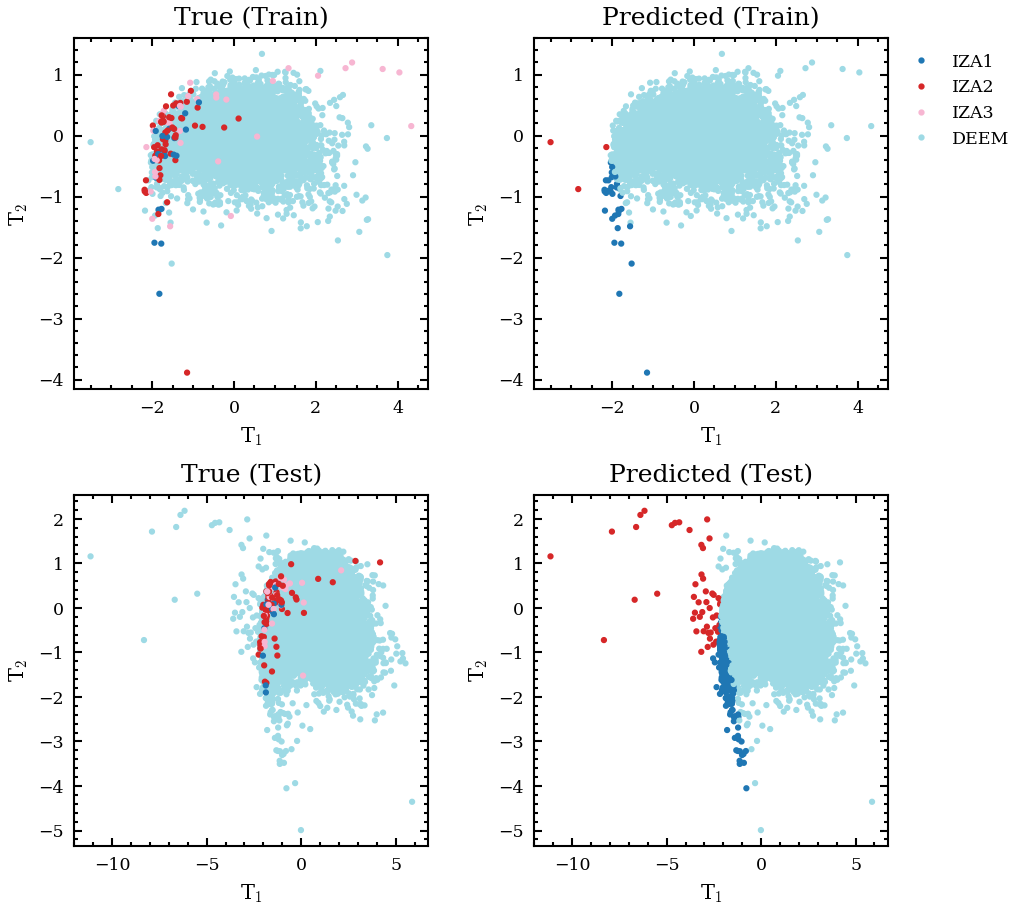

===== 3.5 | 4-Class | Radial | O+Si =====


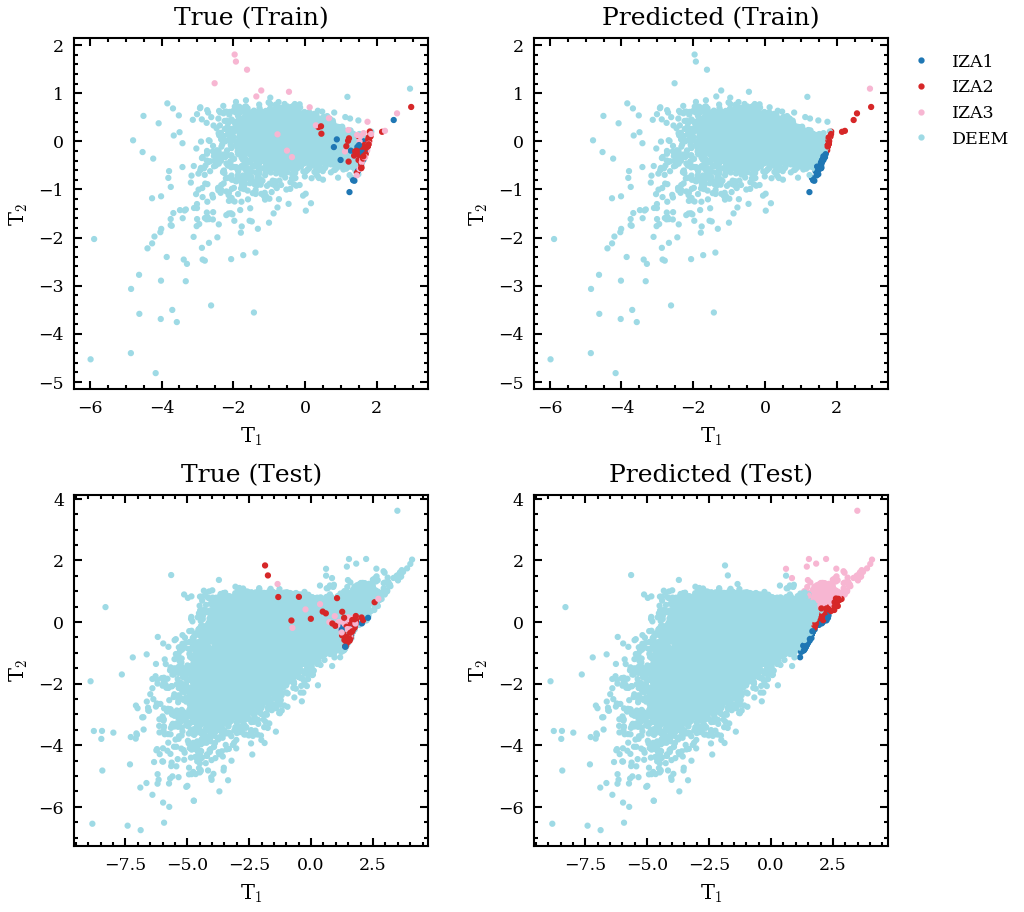

===== 6.0 | 4-Class | Power | OO =====


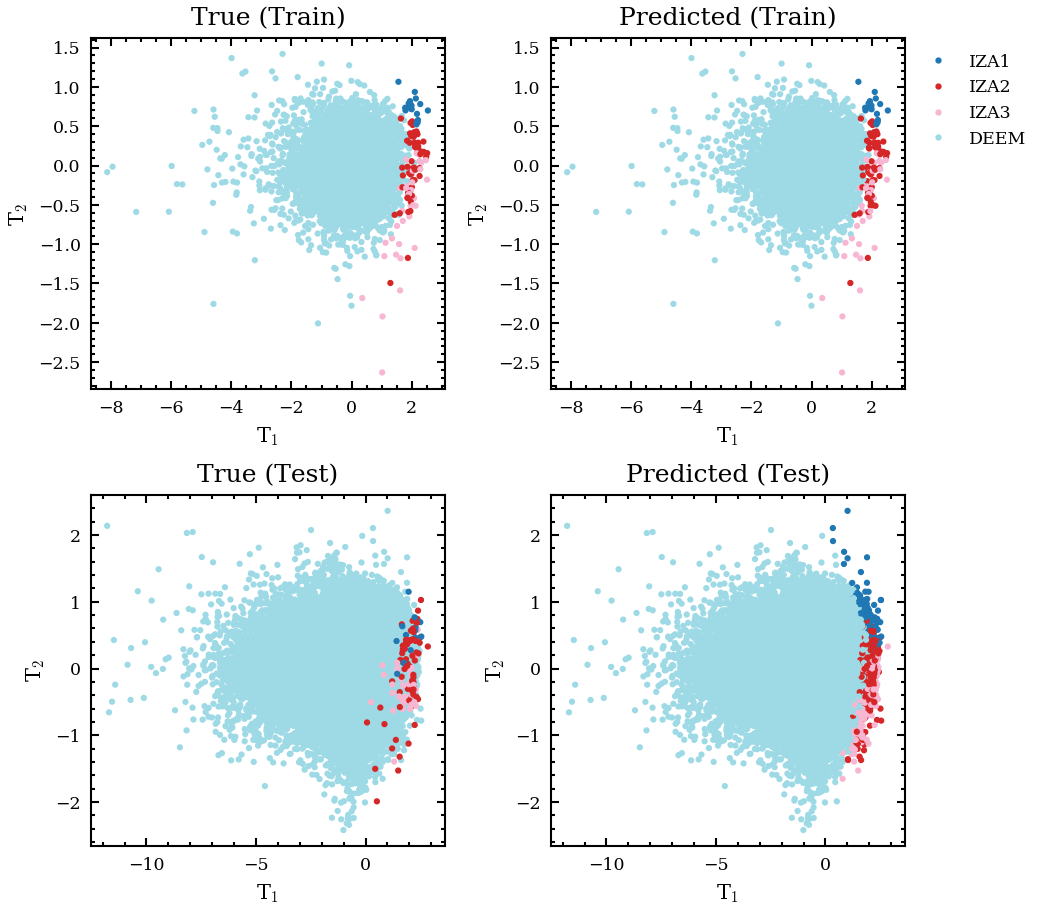

===== 6.0 | 4-Class | Power | OSi =====


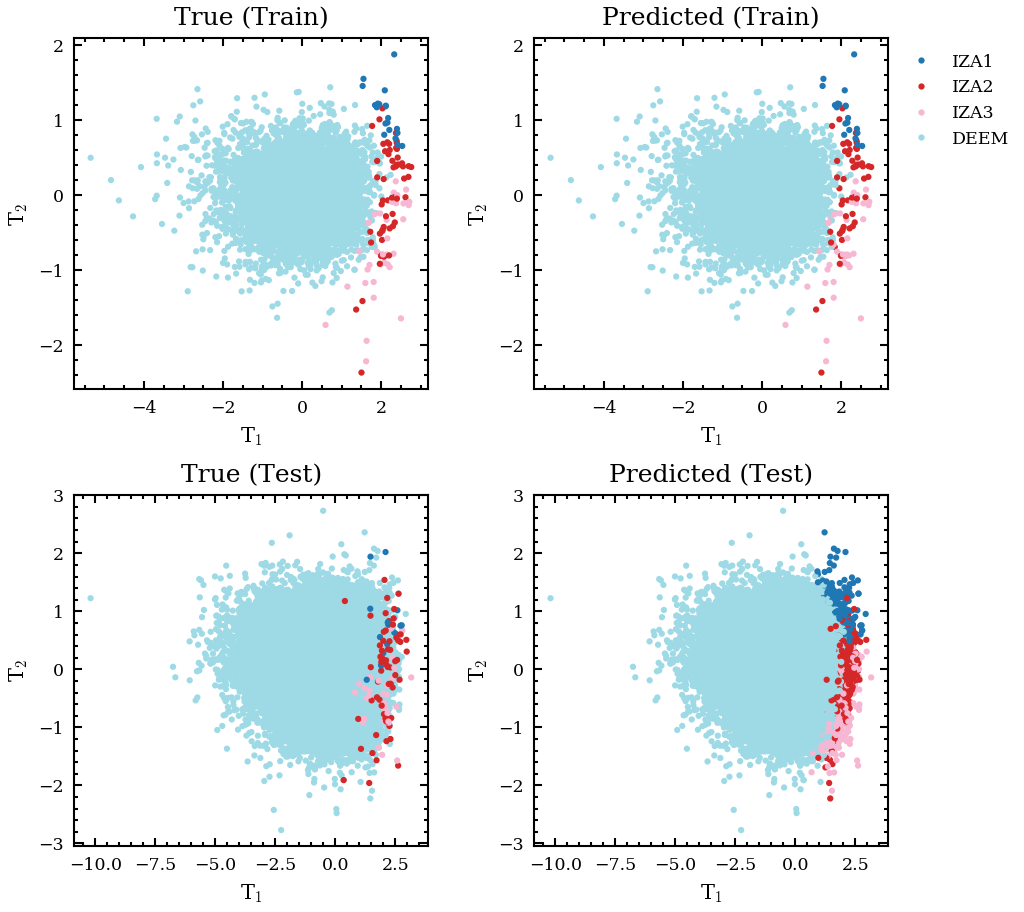

===== 6.0 | 4-Class | Power | SiSi =====


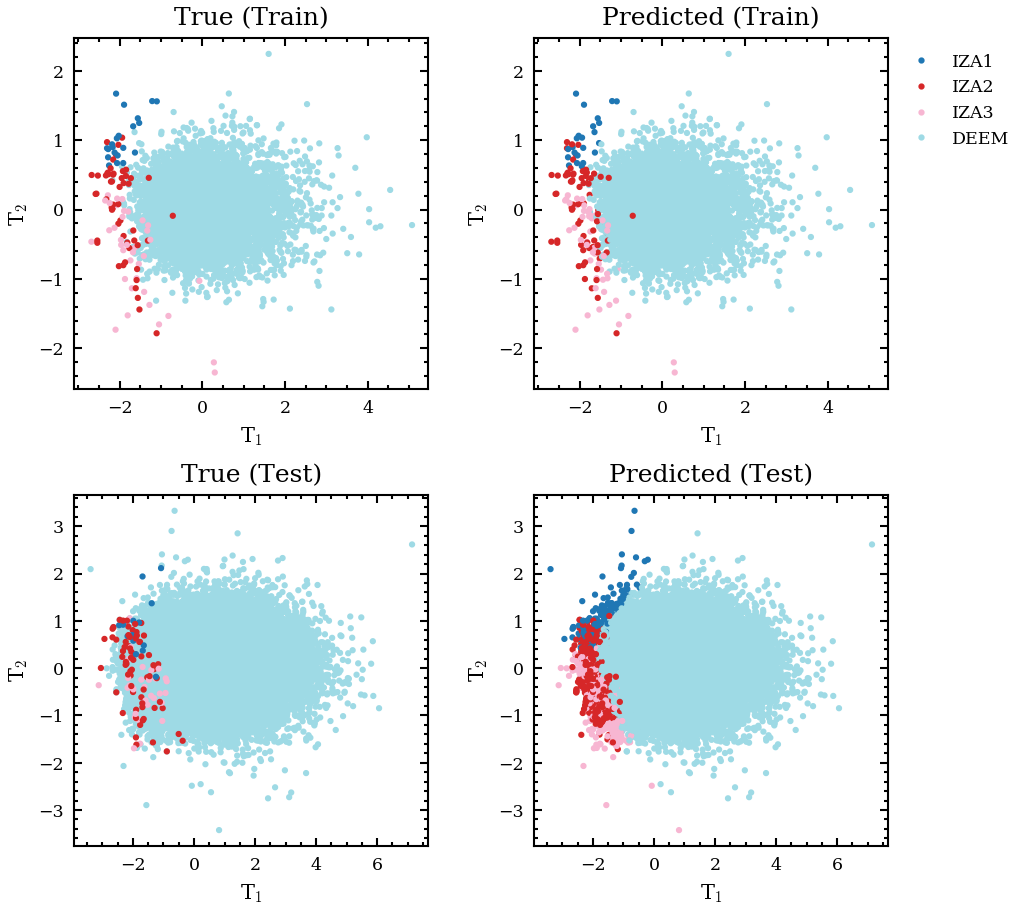

===== 6.0 | 4-Class | Power | OO+OSi =====


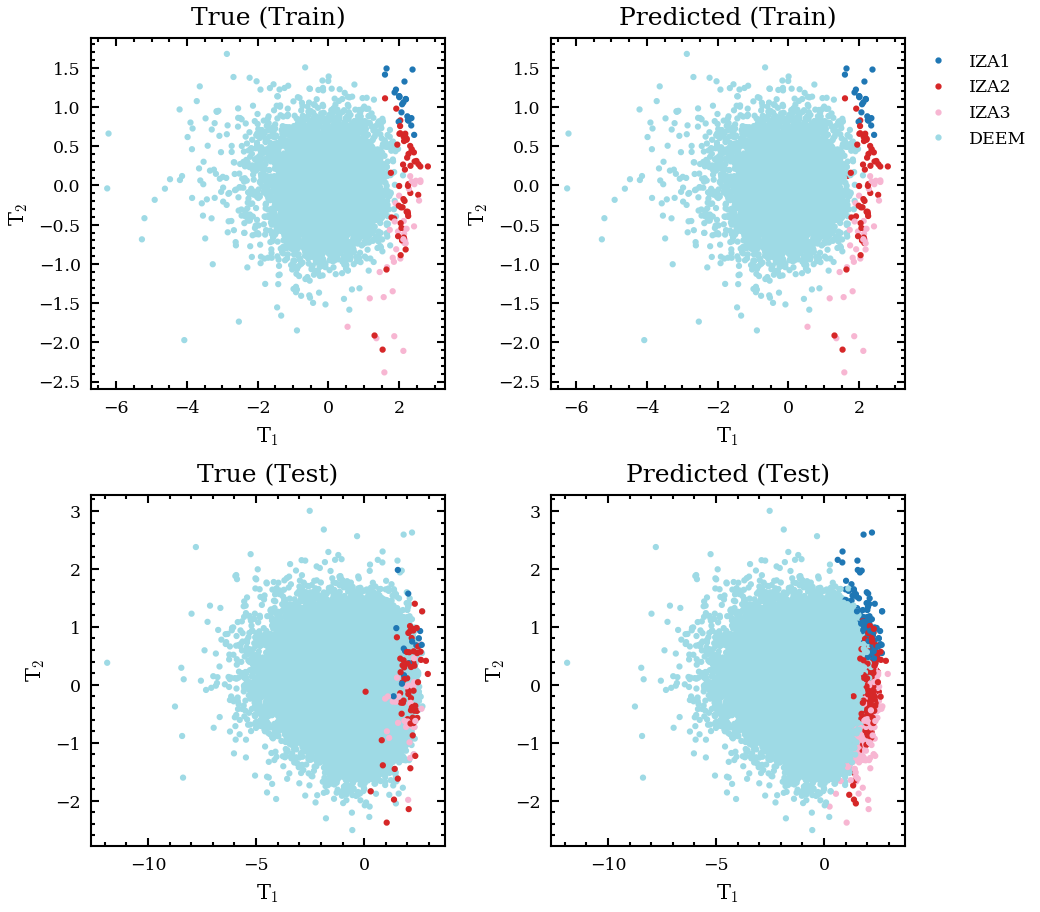

===== 6.0 | 4-Class | Power | OO+SiSi =====


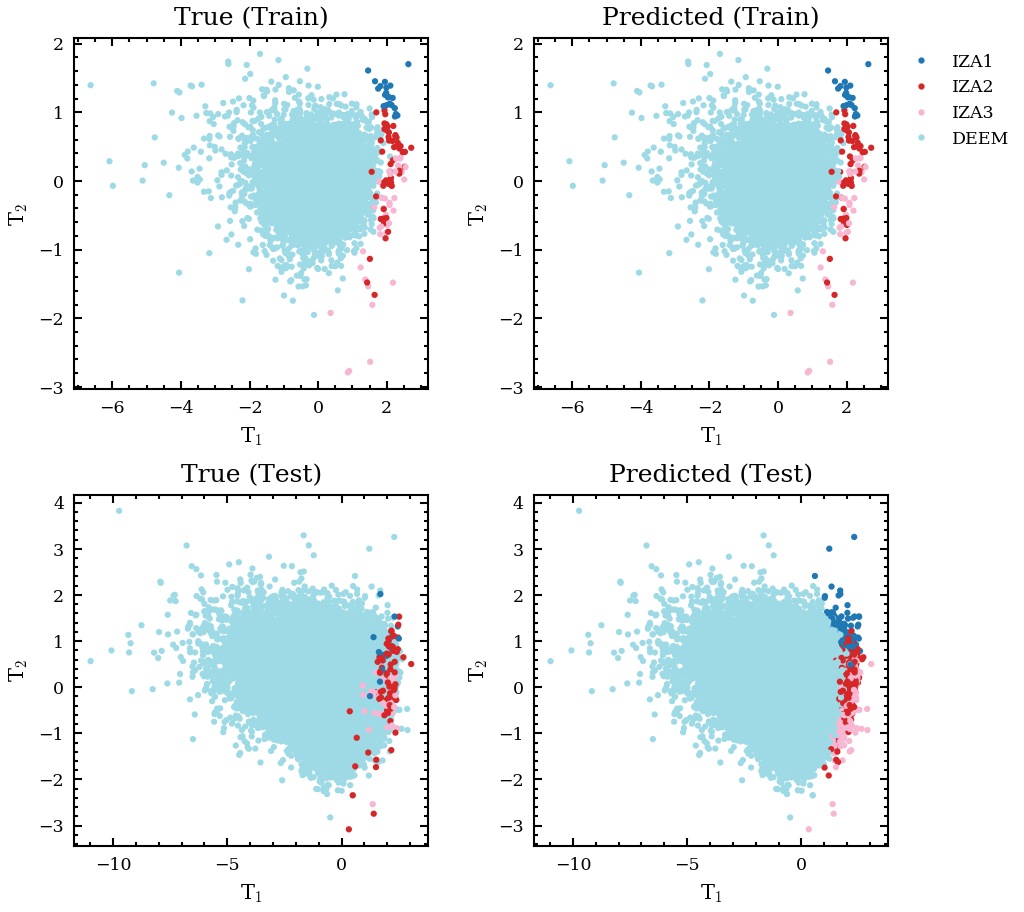

===== 6.0 | 4-Class | Power | OSi+SiSi =====


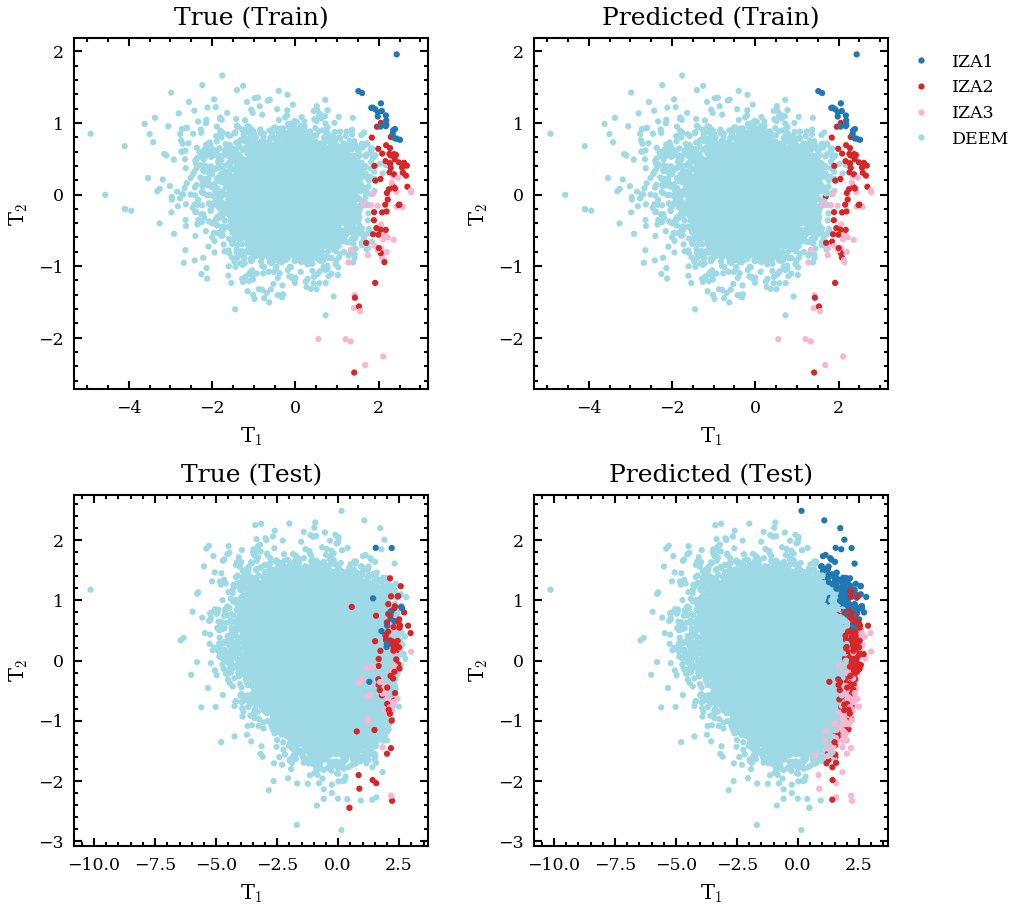

===== 6.0 | 4-Class | Power | OO+OSi+SiSi =====


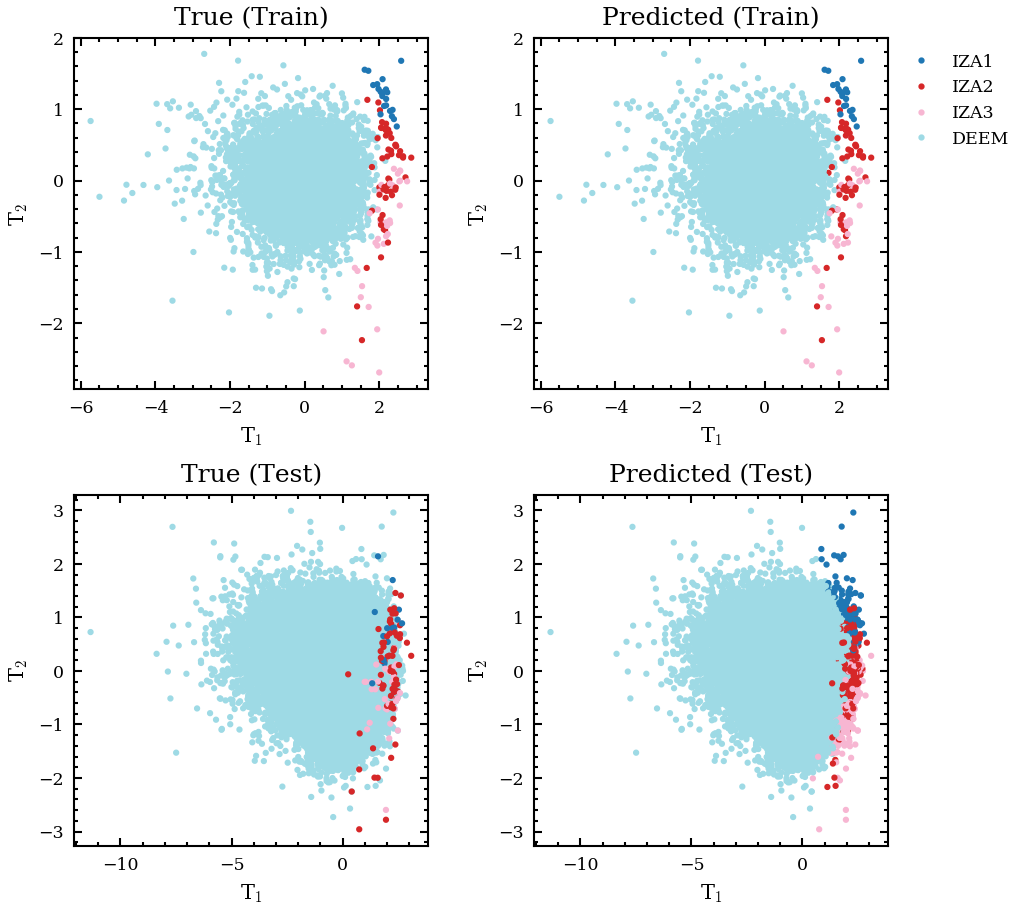

===== 6.0 | 4-Class | Radial | O =====


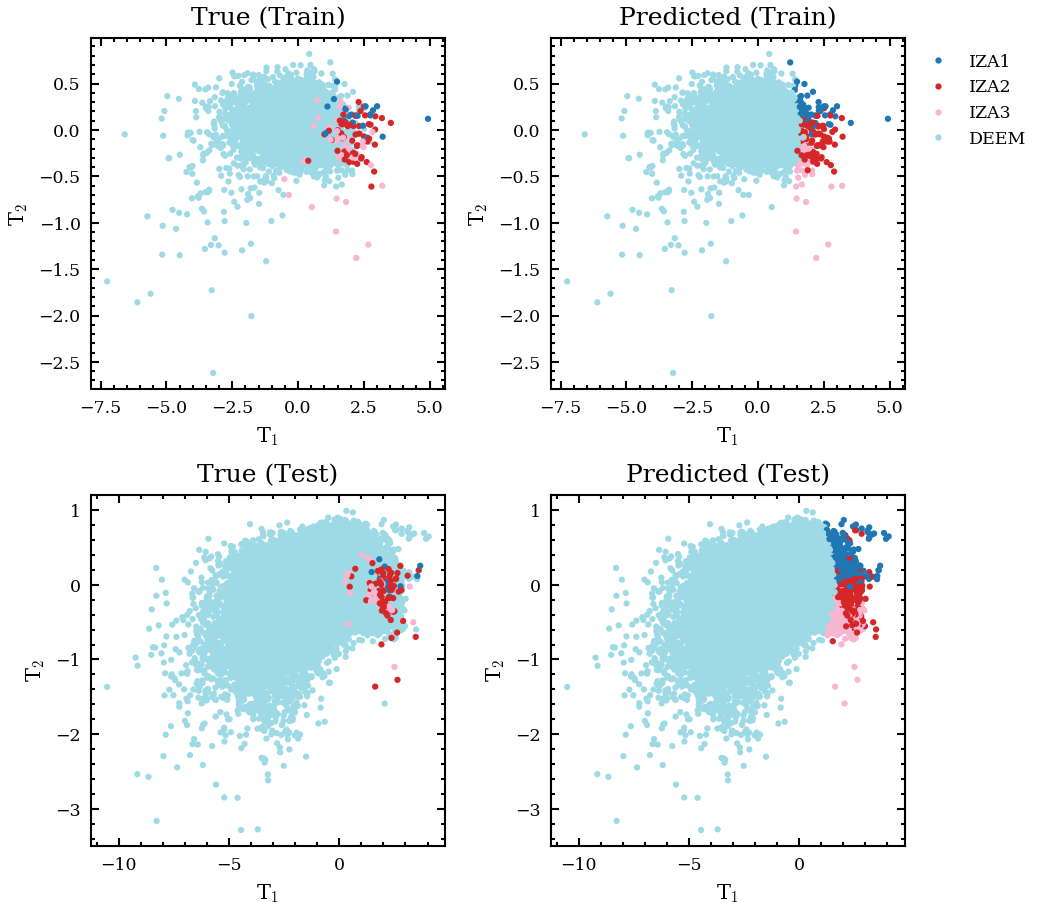

===== 6.0 | 4-Class | Radial | Si =====


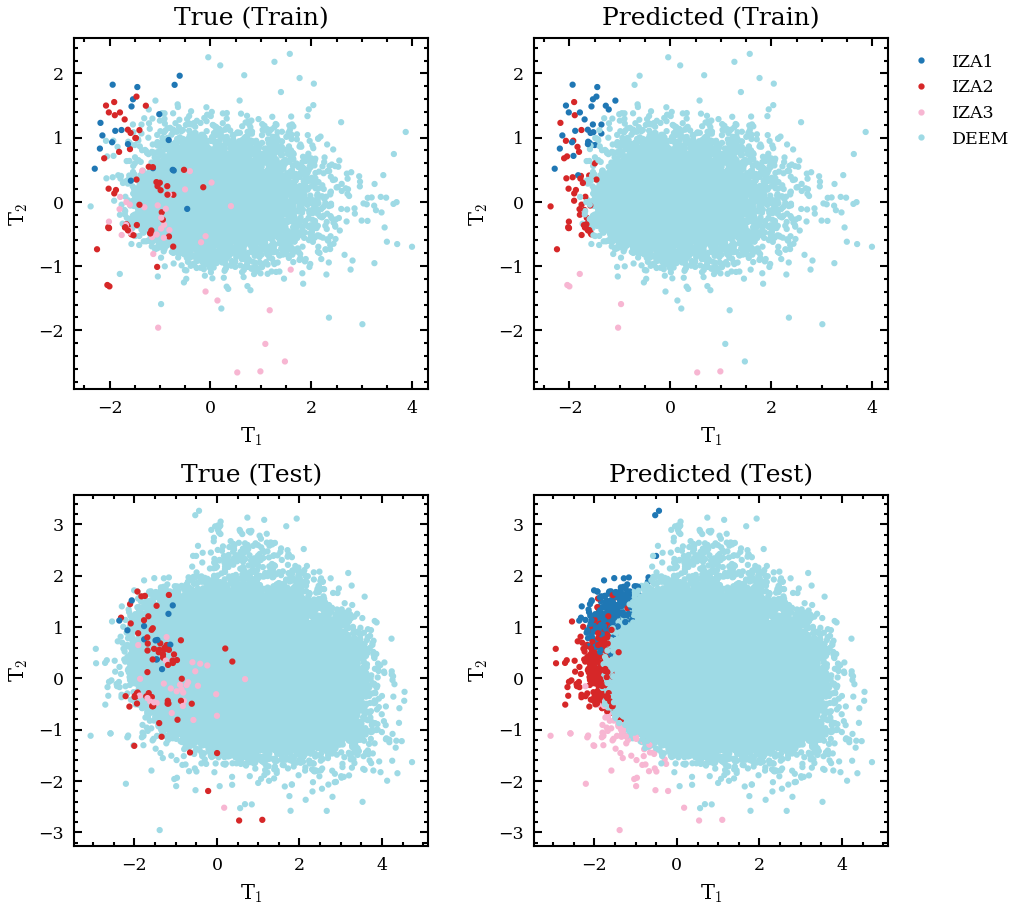

===== 6.0 | 4-Class | Radial | O+Si =====


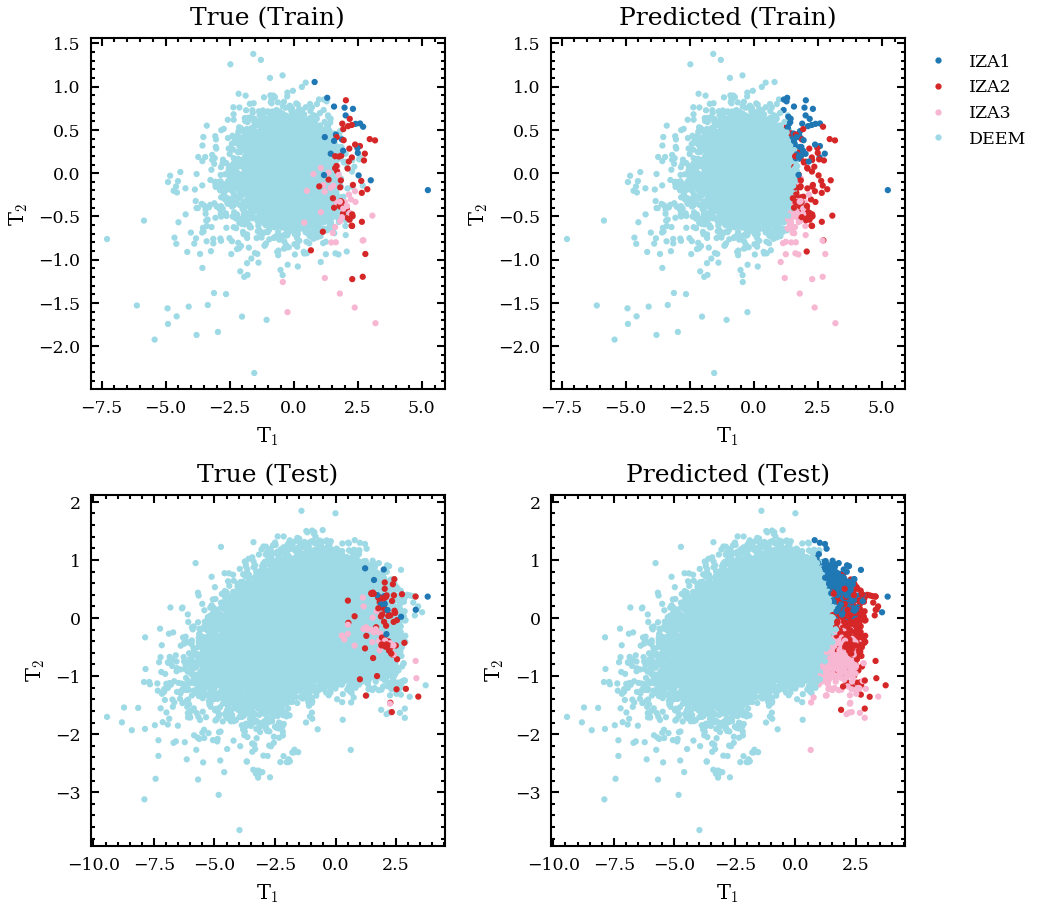

In [46]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in [4]: #(2, 4):
                
                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
                output_dir = f'../../Results/{cutoff}/Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
                
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')
    
                # Load projections
                deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
                T_deem = utils.load_structures_from_hdf5(deem_file, datasets=None, concatenate=True)
                
                all_deem_file = f'{all_deem_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
                T_all_deem = utils.load_structures_from_hdf5(all_deem_file, datasets=None, concatenate=True)
                T_all_deem = np.delete(T_all_deem, 265045, axis=0) # Messed up structure

                iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
                T_iza = utils.load_structures_from_hdf5(iza_file, datasets=None, concatenate=True)

                # Load predicted cantons
                deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
                predicted_cantons_deem = np.loadtxt(deem_file, dtype=int)
                
                all_deem_file = f'{all_deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
                predicted_cantons_all_deem = np.loadtxt(all_deem_file, dtype=int)
                predicted_cantons_all_deem = np.delete(predicted_cantons_all_deem, 265045, axis=0) # Messed up structure

                iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
                predicted_cantons_iza = np.loadtxt(iza_file, dtype=int)

                fig = plt.figure(figsize=(7.0, 7.0))
                axs_true_train = fig.add_subplot(2, 2, 1)
                axs_predicted_train = fig.add_subplot(2, 2, 2)
                axs_true_test = fig.add_subplot(2, 2, 3)
                axs_predicted_test = fig.add_subplot(2, 2, 4)
                scatter_opts = dict(cmap='tab20', vmin=1, vmax=4)
                df_idx = 0

                axs_true_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                            c=cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
                axs_true_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                            c=cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

                axs_predicted_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                            #c=df_deem_train[:, df_idx], zorder=2, **scatter_opts)
                            c=predicted_cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
                axs_predicted_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                            #c=df_iza_train[:, df_idx], zorder=3, **scatter_opts)
                            c=predicted_cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

#                 axs_true_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
#                         c=cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
                axs_true_test.scatter(T_all_deem[:, 0], T_all_deem[:, 1],
                        c=np.ones(len(T_all_deem))*4, zorder=2, **scatter_opts)
                axs_true_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                        c=cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

#                 axs_predicted_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
#                         #c=df_deem_test[:, df_idx])
#                         c=predicted_cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
                axs_predicted_test.scatter(T_all_deem[:, 0], T_all_deem[:, 1],
                        #c=df_deem_test[:, df_idx], zorder=2, **scatter_opts)
                        c=predicted_cantons_all_deem, zorder=2, **scatter_opts)
                axs_predicted_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                        #c=df_iza_test[:, df_idx], zorder=3, **scatter_opts)
                        c=predicted_cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

                handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
                           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
                           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
                           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]

                labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
                axs_predicted_train.legend(handles=handles, labels=labels, 
                                           loc='upper left', bbox_to_anchor=(1.0, 1.0))

                for ax in (axs_true_train, axs_predicted_train, axs_true_test, axs_predicted_test):
                    ax.set_xlabel(r'T$_1$')
                    ax.set_ylabel(r'T$_2$')

                axs_true_train.set_title('True (Train)')
                axs_predicted_train.set_title('Predicted (Train)')
                axs_true_test.set_title('True (Test)')
                axs_predicted_test.set_title('Predicted (Test)')

                fig.subplots_adjust(wspace=0.3, hspace=0.3)

                #fig.savefig(f'{output_dir}/svm-kpcovr.png', bbox_inches='tight')

                plt.show()

## Classification statistics

In [18]:
# Dictionary for holding the misclassified DEEM structures for each knock-out model
misclassified_deem_330k = {}
misclassified_deem_330k_energies = {}
misclassified_deem_330k_volumes = {}

In [19]:
# Population energies and volumes
deem_330k_energies = np.loadtxt('../../Processed_Data/DEEM_330k/structure_energies.dat')
deem_330k_volumes = np.loadtxt('../../Processed_Data/DEEM_330k/structure_volumes.dat')
n_deem_330k = len(deem_330k_energies)

energy_shift = np.mean(deem_330k_energies)

# Load IZA energies and volumes for comparison
iza_energies = np.loadtxt('../../Processed_Data/IZA_226/structure_energies.dat')
iza_volumes = np.loadtxt('../../Processed_Data/IZA_226/structure_volumes.dat')
iza_cantons = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)

### LinearSVC

In [20]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in (2, 4):
                
                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')

                predicted_cantons_iza = \
                    np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
#                 predicted_cantons_deem = \
#                     np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
                predicted_cantons_deem = \
                    np.loadtxt(f'{all_deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

                predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                          predicted_cantons_deem[idxs_deem_train]))
#                 predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
#                                                          predicted_cantons_deem[idxs_deem_test]))
                predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                         predicted_cantons_deem)) ###

                matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
                matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)

                print('----- Train -----')
                print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                            zero_division=0))
                print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
                print()
                print(matrix_train)
                print()

                print('----- Test -----')
                print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                            zero_division=0))
                print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
                print()
                print(matrix_test)
                print()
                
                # Extract structure indices for the misclassified DEEM 330k
                key = f'{cutoff}-{spectrum_type}-{species_pairing}-{n_cantons}'
                misclassified_deem_330k[key] = {}
                for i in range(1, n_cantons):
                    misclassified_deem_330k[key][i] = np.nonzero(predicted_cantons_deem == i)[0]

===== 3.5 | 2-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.21      0.97      0.35       112
           2       1.00      0.95      0.97      7750

    accuracy                           0.95      7862
   macro avg       0.61      0.96      0.66      7862
weighted avg       0.99      0.95      0.96      7862

Train accuracy: 0.9479776138387179

[[ 109    3]
 [ 406 7344]]

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.91      0.01       113
           2       1.00      0.90      0.94    331172

    accuracy                           0.90    331285
   macro avg       0.50      0.90      0.48    331285
weighted avg       1.00      0.90      0.94    331285

Test accuracy: 0.8951325897641004

[[   103     10]
 [ 34731 296441]]

===== 3.5 | 4-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.12  

----- Train -----
              precision    recall  f1-score   support

           1       0.28      0.99      0.43       112
           2       1.00      0.96      0.98      7750

    accuracy                           0.96      7862
   macro avg       0.64      0.98      0.71      7862
weighted avg       0.99      0.96      0.97      7862

Train accuracy: 0.9632409056219792

[[ 111    1]
 [ 288 7462]]

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.89      0.01       113
           2       1.00      0.93      0.97    331172

    accuracy                           0.93    331285
   macro avg       0.50      0.91      0.49    331285
weighted avg       1.00      0.93      0.97    331285

Test accuracy: 0.9337760538509139

[[   101     12]
 [ 21927 309245]]

===== 3.5 | 4-Class | Power | OO+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.54      0.62      0.58        21
     

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.29      0.00        14
           2       0.01      0.28      0.03        68
           3       0.00      0.00      0.00        31
           4       1.00      0.99      0.99    331172

    accuracy                           0.99    331285
   macro avg       0.25      0.39      0.26    331285
weighted avg       1.00      0.99      0.99    331285

Test accuracy: 0.9881612508866988

[[     4      3      0      7]
 [    15     19      0     34]
 [     4      8      0     19]
 [  2534   1249     49 327340]]

===== 3.5 | 2-Class | Radial | Si =====
----- Train -----
              precision    recall  f1-score   support

           1       0.15      0.85      0.26       112
           2       1.00      0.93      0.96      7750

    accuracy                           0.93      7862
   macro avg       0.58      0.89      0.61      7862
weighted avg       0.99      0.93      0.95      7862

Train accuracy: 0.9

              precision    recall  f1-score   support

           1       0.02      0.43      0.04        14
           2       0.04      0.51      0.08        68
           3       0.02      0.52      0.04        31
           4       1.00      0.99      1.00    331172

    accuracy                           0.99    331285
   macro avg       0.27      0.61      0.29    331285
weighted avg       1.00      0.99      1.00    331285

Test accuracy: 0.9941228851291184

[[     6      6      0      2]
 [     9     35     15      9]
 [     2      4     16      9]
 [   243    818    830 329281]]

===== 6.0 | 2-Class | Power | SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.61      1.00      0.76       112
           2       1.00      0.99      1.00      7750

    accuracy                           0.99      7862
   macro avg       0.80      1.00      0.88      7862
weighted avg       0.99      0.99      0.99      7862

Train accuracy: 0.

              precision    recall  f1-score   support

           1       0.02      0.36      0.04        14
           2       0.04      0.51      0.08        68
           3       0.02      0.52      0.04        31
           4       1.00      0.99      1.00    331172

    accuracy                           0.99    331285
   macro avg       0.27      0.60      0.29    331285
weighted avg       1.00      0.99      1.00    331285

Test accuracy: 0.9945726489276605

[[     5      5      0      4]
 [     9     35     12     12]
 [     1      5     16      9]
 [   236    758    747 329431]]

===== 6.0 | 2-Class | Power | OO+OSi+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.85      1.00      0.92       112
           2       1.00      1.00      1.00      7750

    accuracy                           1.00      7862
   macro avg       0.92      1.00      0.96      7862
weighted avg       1.00      1.00      1.00      7862

Train accur

              precision    recall  f1-score   support

           1       0.01      0.57      0.01        14
           2       0.01      0.54      0.03        68
           3       0.00      0.19      0.00        31
           4       1.00      0.98      0.99    331172

    accuracy                           0.98    331285
   macro avg       0.26      0.57      0.26    331285
weighted avg       1.00      0.98      0.99    331285

Test accuracy: 0.9797817589084927

[[     8      6      0      0]
 [    13     37     11      7]
 [     3      7      6     15]
 [  1332   2522   2782 324536]]



In [21]:
misclassification_counts = np.zeros(n_deem_330k)

In [22]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        for species_pairing in group_names[spectrum_type]:
            for n_cantons in (2, 4):
                key = f'{cutoff}-{spectrum_type}-{species_pairing}-{n_cantons}'
                
                misclassified_deem_330k_energies[key] = {}
                misclassified_deem_330k_volumes[key] = {}
                
                for i in range(1, n_cantons):
                    structure_idxs = misclassified_deem_330k[key][i]
                    misclassified_deem_330k_energies[key][i] = deem_330k_energies[structure_idxs]
                    misclassified_deem_330k_volumes[key][i] = deem_330k_volumes[structure_idxs]
                    misclassification_counts[structure_idxs] += 1
                
#                 print(f'===== {key} =====')
#                 print()
#                 for i in range(1, n_cantons):
#                     print(i, misclassified_deem_330k[key][i])
#                 print()

In [23]:
print(misclassification_counts)
print(np.count_nonzero(misclassification_counts < 1))
print(np.argsort(misclassification_counts))
print(np.sort(misclassification_counts))
print(np.count_nonzero(misclassification_counts == 40))
print(np.nonzero(misclassification_counts == 40))

[ 9.  2.  3. ...  5. 32.  0.]
194410
[165585 176841 176843 ... 116203  14244 330881]
[ 0.  0.  0. ... 40. 40. 40.]
8
(array([ 14244,  66457, 115811, 116203, 271372, 315375, 315376, 330881]),)


In [24]:
print(np.mean(misclassification_counts))
print(np.std(misclassification_counts))

2.0051634800043483
4.16859221121753


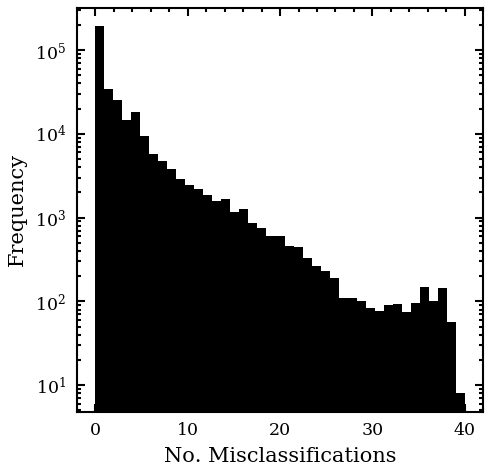

In [25]:
fig = plt.figure(figsize=(3.5, 3.5))
ax = fig.add_subplot(1, 1, 1)

ax.hist(misclassification_counts, bins=41, density=False, log=True)
ax.set_xlabel('No. Misclassifications')
ax.set_ylabel('Frequency')

fig.savefig('../../Results/misclassification_number_histogram.pdf', bbox_inches='tight')

plt.show()

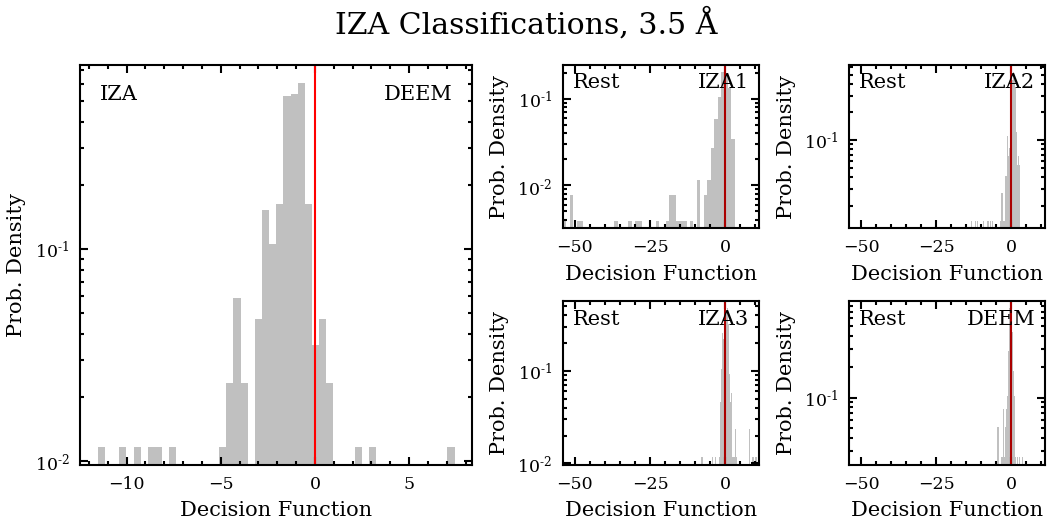

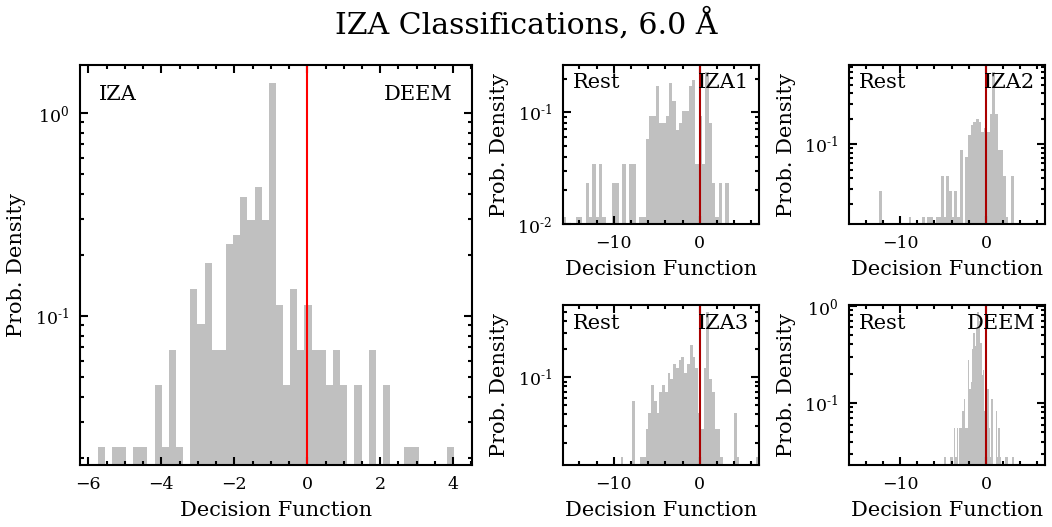

In [58]:
for cutoff in cutoffs:
    fig = plt.figure(figsize=(7.0, 3.5), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 1), height_ratios=(1, 1))

    axs_2 = fig.add_subplot(gs[0:2, 0:2])
    axs_4 = [fig.add_subplot(gs[i // 2, 2 + (i % 2)]) for i in range(0, 4)]

    dfs_2 = np.loadtxt(f'../../Processed_Data/IZA_226/Data/{cutoff}/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
    dfs_4 = np.loadtxt(f'../../Processed_Data/IZA_226/Data/{cutoff}/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
    histogram_parameters = dict(bins=50, density=True, log=True, color='silver')

    df_4_min = np.amin(dfs_4)
    df_4_max = np.amax(dfs_4)

    # 2-Class histogram
    axs_2.hist(dfs_2, **histogram_parameters)
    axs_2.set_xlabel('Decision Function')
    axs_2.set_ylabel('Prob. Density')
    axs_2.axvline(0, color='r')

    axs_2.text(0.05, 0.95, class_names[2][0], verticalalignment='top', horizontalalignment='left',
               transform=axs_2.transAxes)
    axs_2.text(0.95, 0.95, class_names[2][1], verticalalignment='top', horizontalalignment='right',
               transform=axs_2.transAxes)

    # 4-Class histograms
    for adx, ax in enumerate(axs_4):
        ax.hist(dfs_4[:, adx], **histogram_parameters)
        ax.set_xlabel('Decision Function')
        ax.set_ylabel('Prob. Density')
        ax.axvline(0, color=color_list[1])
        ax.set_xlim([df_4_min, df_4_max])

        ax.text(0.05, 0.95, 'Rest', verticalalignment='top', horizontalalignment='left',
                transform=ax.transAxes)
        ax.text(0.95, 0.95, class_names[4][adx], verticalalignment='top', horizontalalignment='right',
                transform=ax.transAxes)

    fig.suptitle(f'IZA Classifications, {cutoff} ' + u'\u00c5')

    fig.savefig(f'../../Results/df_iza_histogram_{cutoff}_power_OO+OSi+SiSi_lsvc.pdf', bbox_inches='tight')
    plt.show()

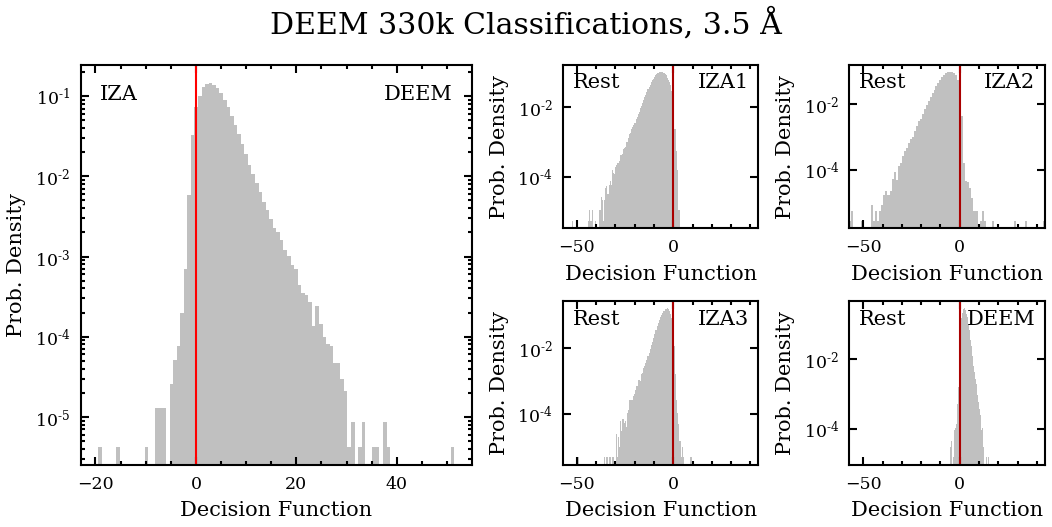

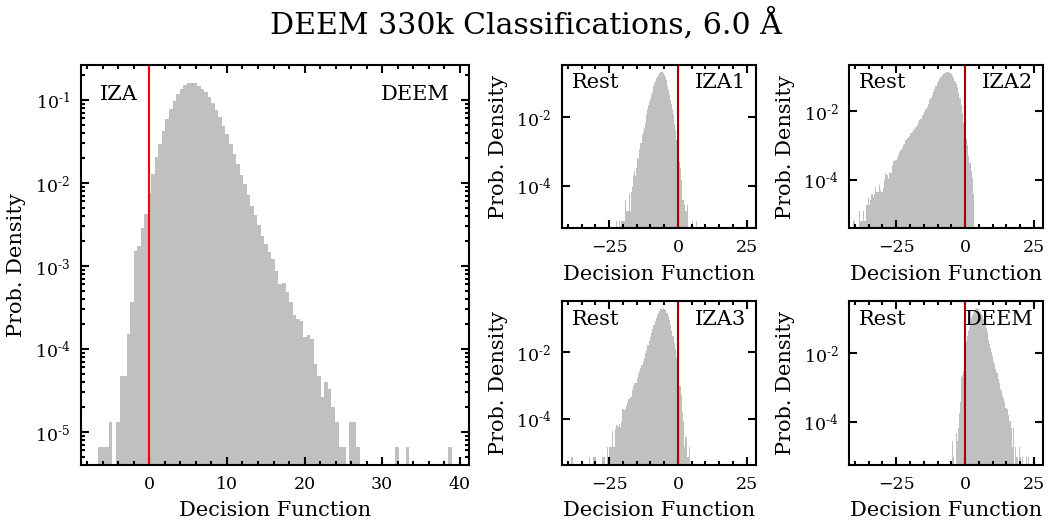

In [34]:
for cutoff in cutoffs:
    fig = plt.figure(figsize=(7.0, 3.5), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 1), height_ratios=(1, 1))

    axs_2 = fig.add_subplot(gs[0:2, 0:2])
    axs_4 = [fig.add_subplot(gs[i // 2, 2 + (i % 2)]) for i in range(0, 4)]

    dfs_2 = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/{cutoff}/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
    dfs_4 = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/{cutoff}/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
    histogram_parameters = dict(bins=100, density=True, log=True, color='silver')

    df_4_min = np.amin(dfs_4)
    df_4_max = np.amax(dfs_4)

    # 2-Class histogram
    axs_2.hist(dfs_2, **histogram_parameters)
    axs_2.set_xlabel('Decision Function')
    axs_2.set_ylabel('Prob. Density')
    axs_2.axvline(0, color='r')

    axs_2.text(0.05, 0.95, class_names[2][0], verticalalignment='top', horizontalalignment='left',
               transform=axs_2.transAxes)
    axs_2.text(0.95, 0.95, class_names[2][1], verticalalignment='top', horizontalalignment='right',
               transform=axs_2.transAxes)

    # 4-Class histograms
    for adx, ax in enumerate(axs_4):
        ax.hist(dfs_4[:, adx], **histogram_parameters)
        ax.set_xlabel('Decision Function')
        ax.set_ylabel('Prob. Density')
        ax.axvline(0, color=color_list[1])
        ax.set_xlim([df_4_min, df_4_max])

        ax.text(0.05, 0.95, 'Rest', verticalalignment='top', horizontalalignment='left',
                transform=ax.transAxes)
        ax.text(0.95, 0.95, class_names[4][adx], verticalalignment='top', horizontalalignment='right',
                transform=ax.transAxes)

    fig.suptitle(f'DEEM 330k Classifications, {cutoff} ' + u'\u00c5')

    fig.savefig(f'../../Results/df_histogram_{cutoff}_power_OO+OSi+SiSi_lsvc.pdf', bbox_inches='tight')
    plt.show()

In [27]:
dfs_4

array([[-8.86723915, -3.45813802, -4.05752996,  2.52700265],
       [-8.28944458, -5.36724987, -4.08528029,  3.61593371],
       [-6.946055  , -4.9526911 , -4.57753087,  3.56466801],
       ...,
       [-3.02314826, -4.62161382, -3.96719527,  2.31837067],
       [ 1.16290802,  0.51075704, -6.86372307, -1.64622607],
       [-2.77719885, -8.07316193, -8.78921622,  6.1948548 ]])

In [28]:
#dfs_4_norm = (dfs_4 - np.amin(dfs_4, axis=0)) /  (np.amax(dfs_4, axis=0) - np.amin(dfs_4, axis=0))
dfs_4_norm = (dfs_4 - np.amin(dfs_4)) /  (np.amax(dfs_4) - np.amin(dfs_4))
print(dfs_4_norm)

[[0.4727671  0.54940943 0.54091656 0.63421374]
 [0.48095395 0.52235895 0.54052336 0.64964296]
 [0.49998863 0.52823289 0.53354859 0.64891657]
 ...
 [0.55557286 0.53292397 0.54219652 0.6312576 ]
 [0.61488569 0.60564527 0.50115521 0.57508267]
 [0.55905775 0.48401849 0.47387262 0.68618406]]


In [29]:
dfs_4_norm.sum(axis=1)

array([2.19730682, 2.19347922, 2.21068668, ..., 2.26195096, 2.29676883,
       2.20313292])

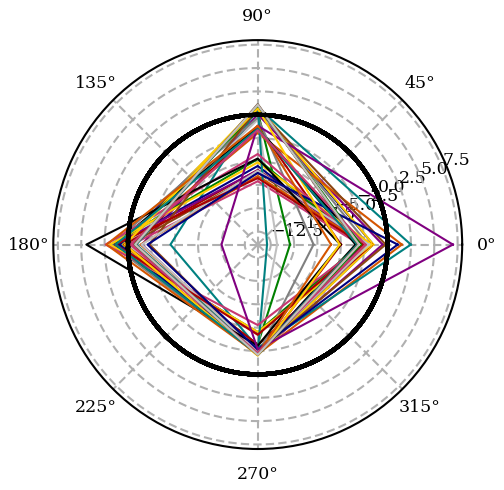

In [30]:
# This doesn't work well because of outliers. Can we make a metric less sensitive to them?
# TODO: try normalizing **including IZA** in two chunks: negative and positive
theta = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
# for i in range(0, 1000):
#     #plt.polar(theta, np.concatenate((dfs_4_norm[i], np.array([dfs_4_norm[i, 0]]))))
#     plt.polar(theta, np.concatenate((dfs_4[i], np.array([dfs_4[i, 0]]))))

dfs_4_select = dfs_4[dfs_4[:, -1] < -2]
for df4s in dfs_4_select:
    plt.polar(theta, np.concatenate((df4s, np.array([df4s[0]]))))

    plt.polar(np.linspace(0, 2*np.pi, 100), np.zeros(100), color='k', linewidth=2)
plt.show()

In [64]:
# Most IZA-like Deem structures (lowest decision function value)
dfs_2 = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
most_iza = np.argsort(dfs_2)
print(most_iza[0:5] + 8000001)
print(dfs_2[most_iza[0:5]])

[8283748 8204697 8162065 8162069 8308516]
[-6.57037879 -5.71150898 -5.59798227 -5.09789729 -4.79237904]


In [65]:
# Most Deem-like Deem
print(most_iza[-5:] + 8000001)
print(dfs_2[most_iza[-5:]])

[8126142 8229490 8171811 8321582 8129504]
[26.38966095 27.0171406  31.81661745 33.15937404 38.93749711]


In [66]:
# Most IZA-like IZA
iza_codes = np.loadtxt(f'../../Raw_Data/GULP/IZA_226/codes.txt', dtype=str)
dfs_2 = np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
most_iza = np.argsort(dfs_2)
print(dfs_2[most_iza[0:5]])
print(iza_codes[most_iza[0:5]])

[-5.749144 -5.235089 -5.073022 -4.657748 -4.380531]
['OPT_MTN' 'OPT_MTT' 'OPT_TOL' 'OPT_MEP' 'OPT_SBE']


In [67]:
# Most Deem-like IZA
print(dfs_2[most_iza[-5:]])
print(iza_codes[most_iza[-5:]])

[2.080585 2.158487 2.789828 3.048626 4.031236]
['OPT_PON' 'OPT_VFI' 'OPT_JNT' 'OPT_APC' 'OPT_MVY']


In [ ]:
fig = plt.figure(figsize=(7.0, 3.5))
axs_vol = fig.add_subplot(1, 2, 1)
axs_energy = fig.add_subplot(1, 2, 2)

histogram_parameters = dict(bins=50, density=True, alpha=0.5)
energy_range = (np.amin(deem_330k_energies-energy_shift), np.amax(deem_330k_energies-energy_shift))
volume_range = (np.amin(deem_330k_volumes), np.amax(deem_330k_volumes))

plot_key = '6.0-power-OO+OSi+SiSi-4'

axs_vol.hist(deem_330k_volumes, range=volume_range, 
             **histogram_parameters, label='Population')
axs_energy.hist(deem_330k_energies-energy_shift, range=energy_range, 
                **histogram_parameters, label='Population')

for class_key in misclassified_deem_330k[plot_key].keys():
    axs_vol.hist(misclassified_deem_330k_volumes[plot_key][class_key], range=volume_range,
                 **histogram_parameters, label=f'IZA{class_key}*')
    axs_energy.hist(misclassified_deem_330k_energies[plot_key][class_key]-energy_shift, range=energy_range, 
                    **histogram_parameters, label=f'IZA{class_key}*')
    
axs_energy.legend()

axs_vol.set_title('Volume per Si')
axs_vol.set_xlabel(u'Volume (\u00c5' + r'$^3$/Si atom)')
axs_vol.set_ylabel('Prob. Density')
#axs_vol.set_xlim([np.amin(deem_330k_volumes), 80])

axs_energy.set_title('Energy per Si')
axs_energy.set_xlabel('Energy (kJ/mol Si)')
axs_energy.set_ylabel('Prob. Density')


fig.suptitle('DEEM 330k')
fig.subplots_adjust(wspace=0.3)

fig.savefig('../../Results/deem_property_histogram.pdf', bbox_inches='tight')
    
plt.show()

In [ ]:
fig = plt.figure(figsize=(7.0, 3.5))
axs_vol = fig.add_subplot(1, 2, 1)
axs_energy = fig.add_subplot(1, 2, 2)

histogram_parameters = dict(bins=50, density=True, alpha=0.5)
energy_range = (np.amin(deem_330k_energies-energy_shift), np.amax(deem_330k_energies-energy_shift))
volume_range = (np.amin(deem_330k_volumes), np.amax(deem_330k_volumes))

axs_vol.hist(iza_volumes, range=volume_range, **histogram_parameters, label='Population')
axs_energy.hist(iza_energies-energy_shift, range=energy_range, **histogram_parameters, label='Population')

# Skip RWY (canton 4)
for i in np.unique(iza_cantons)[0:-1]:
    canton_idxs = np.nonzero(iza_cantons == i)[0]
    axs_vol.hist(iza_volumes[canton_idxs], range=volume_range,
                 **histogram_parameters, label=f'IZA{class_key}')
    axs_energy.hist(iza_energies[canton_idxs]-energy_shift, range=energy_range,
                    **histogram_parameters, label=f'IZA{class_key}')
    
axs_energy.legend()

axs_vol.set_title('Volume per Si')
axs_vol.set_xlabel(u'Volume (\u00c5' + r'$^3$/Si atom)')
axs_vol.set_ylabel('Prob. Density')
#axs_vol.set_xlim([np.amin(deem_330k_volumes), 80])

axs_energy.set_title('Energy per Si')
axs_energy.set_xlabel('Energy (kJ/mol Si)')
axs_energy.set_ylabel('Prob. Density')

fig.suptitle('IZA')
fig.subplots_adjust(wspace=0.3)

fig.savefig('../../Results/iza_property_histogram.pdf', bbox_inches='tight')
    
plt.show()

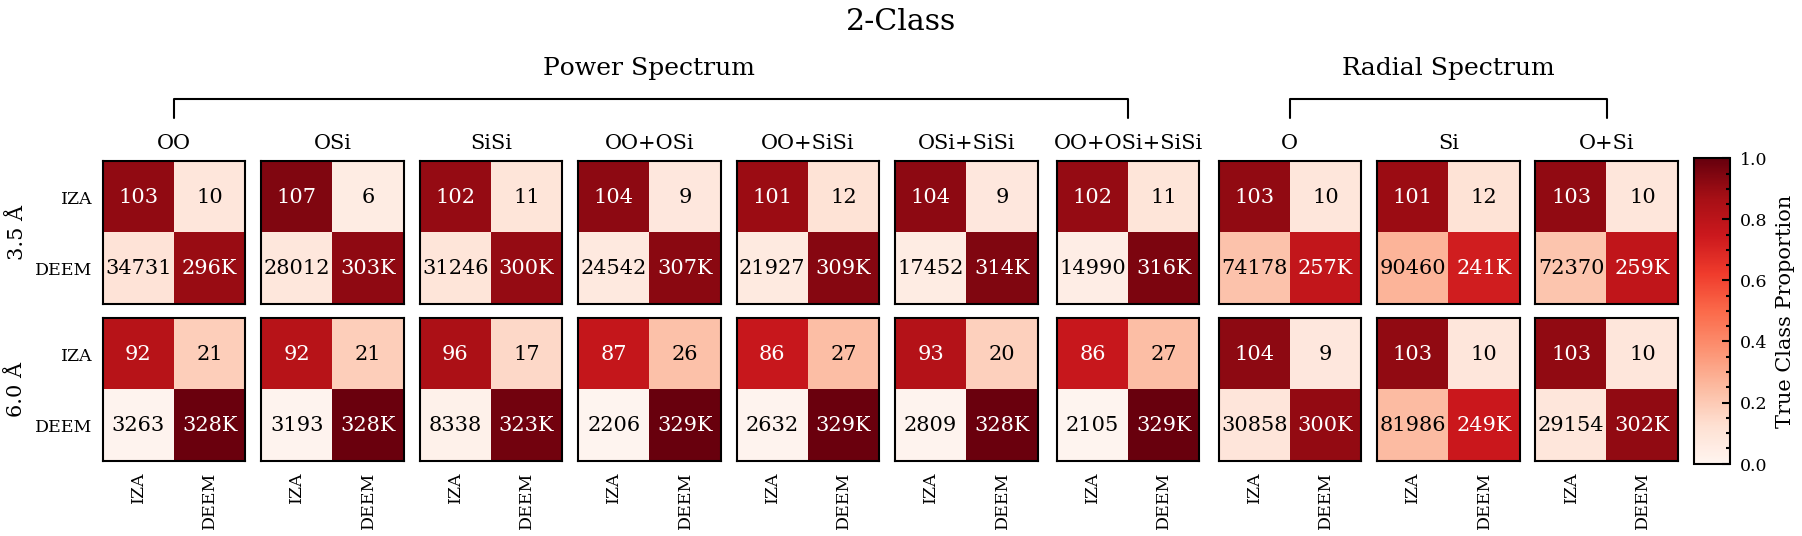

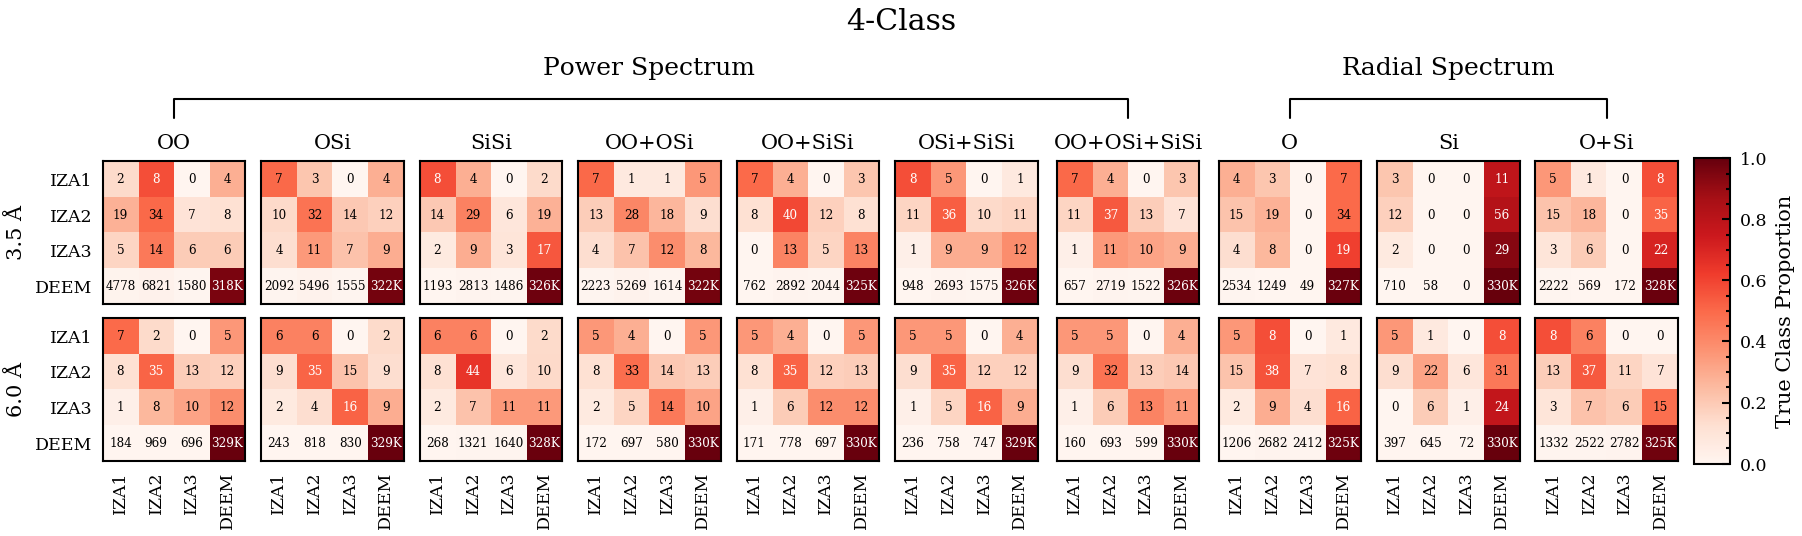

In [28]:
fig_2class = plt.figure(figsize=(12, 2.7), constrained_layout=True)
fig_4class = plt.figure(figsize=(12, 2.7), constrained_layout=True)

n_rows = 2
n_cols = 10

vmin = 0.0 #-len(idxs_iza_test)
vmax = 1.0 #len(idxs_iza_test)

width_ratios = np.ones(n_cols + 1)
width_ratios[-1] = 0.25

for fig, n_cantons in zip((fig_2class, fig_4class), (2, 4)):
    gs = fig.add_gridspec(nrows=n_rows, ncols=n_cols+1, 
                          width_ratios=width_ratios,
                          hspace=0.05, wspace=0.05)
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(0, n_cols)] for i in range(0, n_rows)])
    row_idx = 0
    for cutoff in cutoffs:
        col_idx = 0
        for spectrum_type in ('power', 'radial'):
            spectrum_name = spectrum_type.capitalize()

            for species_pairing in group_names[spectrum_type]:

                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'

                predicted_cantons_iza = \
                    np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
#                 predicted_cantons_deem = \
#                     np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
                predicted_cantons_deem = \
                    np.loadtxt(f'{all_deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

                predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                          predicted_cantons_deem[idxs_deem_train]))
#                 predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
#                                                          predicted_cantons_deem[idxs_deem_test]))
                predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                         predicted_cantons_deem))

#                 dummy_cantons = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/dummy_svc_structure_cantons.dat', dtype=int) ###
#                 predicted_cantons_train = dummy_cantons[idxs_deem_train] ###
#                 predicted_cantons_test = dummy_cantons[idxs_deem_test] ###

                matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
                matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)

#                 matrix_train = confusion_matrix(dummy_cantons_deem_train[n_cantons], predicted_cantons_train) ###
#                 matrix_test = confusion_matrix(dummy_cantons_deem_test[n_cantons], predicted_cantons_test) ###

                matrix_ref = np.zeros((n_cantons, n_cantons), dtype=int)
                for i in range(0, n_cantons):
                    matrix_ref[i, i] = np.count_nonzero(cantons_test[n_cantons] == (i + 1))
#                     matrix_ref[i, i] = np.count_nonzero(dummy_cantons_deem_test[n_cantons] == (i + 1)) ###
                    
                matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]
                
                ax = axes[row_idx, col_idx]
                ax.imshow(matrix_norm, cmap='Reds', vmin=vmin, vmax=vmax)
                
                if n_cantons == 2:
                    text_size = 'medium'
                else:
                    text_size = 'xx-small'
                
                for i in range(0, n_cantons):
                    for j in range(0, n_cantons):
                        if matrix_norm[i, j] > (0.5 * vmax):
                            text_color = 'w'
                        else:
                            text_color = 'k'
                            
                        if len(str(matrix_test[i, j])) > 5:
                            
                            # This isn't a very 'robust' way of doing this,
                            # but since we only go up to 6 digits, this should work
                            # (we do this shortening only if the number has 6 digits)
                            box_number_str = str(round(matrix_test[i, j], -3))
                            box_number_str = box_number_str[0:-3] + 'K'
                        else:
                            box_number_str = f'{matrix_test[i, j]:d}'
                        
                        ax.text(j, i, box_number_str,
                                horizontalalignment='center', verticalalignment='center',
                                color=text_color, fontsize=text_size)
                
                ax.set_xticks(np.arange(0, n_cantons))
                ax.set_yticks(np.arange(0, n_cantons))
                
                ax.tick_params(axis='both', which='both', 
                               left=False, bottom=False, right=False, top=False,
                               labelleft=False, labelbottom=False, labelright=False, labeltop=False)
                
                if col_idx == 0:
                    ax.set_ylabel(f'{cutoff} ' + u'\u00c5')
                    ax.set_yticklabels(ticklabels[n_cantons])
                    ax.tick_params(axis='y', which='both', labelleft=True)
                    
                if row_idx == 0:
                    ax.set_title(f'{species_pairing}', fontsize='medium')
                elif row_idx == (n_rows - 1):
                    ax.set_xticklabels(ticklabels[n_cantons], rotation=90)
                    ax.tick_params(axis='x', which='both', labelbottom=True)

                col_idx += 1
        
        row_idx += 1        
    
    cp_xy = (0.5, 1.3)
    cp_power_bar_frac = -0.02
    cp_radial_bar_frac = cp_power_bar_frac * 3
    cp_power = ConnectionPatch(xyA=cp_xy, coordsA=axes[0, 0].transAxes,
                               xyB=cp_xy, coordsB=axes[0, 6].transAxes,
                               connectionstyle=f'bar,fraction={cp_power_bar_frac}')
    cp_radial = ConnectionPatch(xyA=cp_xy, coordsA=axes[0, 7].transAxes,
                                xyB=cp_xy, coordsB=axes[0, 9].transAxes,
                               connectionstyle=f'bar,fraction={cp_radial_bar_frac}')
    
    n_power = len(group_names['power'])
    n_radial = len(group_names['radial'])
    
    power_label_ax = axes[0, n_power // 2]
    if n_power % 2 == 0:
        power_shift = 0.5
    else:
        power_shift = 0.0
        
    radial_label_ax = axes[0, n_radial // 2 + n_power]
    if n_radial % 2 == 0:
        radial_shift = 0.5
    else:
        radial_shift = 0.0
    
    fig.text(0.5 - power_shift, 1.65, 'Power Spectrum',
             horizontalalignment='center', verticalalignment='center',
             transform=power_label_ax.transAxes, fontsize='large')
    
    fig.text(0.5 - radial_shift, 1.65, 'Radial Spectrum',
             horizontalalignment='center', verticalalignment='center',
             transform=radial_label_ax.transAxes, fontsize='large')
    
    cax = fig.add_subplot(gs[:, -1])
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='Reds'), 
                      cax=cax)
    cb.set_label('True Class Proportion')
    
    fig.add_artist(cp_power)
    fig.add_artist(cp_radial)
    fig.suptitle(f'{n_cantons}-Class', y=1.3)
    
    #fig.savefig(f'../../Results/svc_confusion_matrices_{n_cantons}-class.pdf', bbox_inches='tight')
    #fig.savefig(f'../../Results/dummy_svc_confusion_matrices_{n_cantons}-class.pdf', bbox_inches='tight')
    fig.savefig(f'../../Results/all_deem_svc_confusion_matrices_{n_cantons}-class.pdf', bbox_inches='tight')
    
plt.show()

### PCovR

In [49]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in (2, 4):
                
                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')            
                
                predicted_cantons_iza = \
                    np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)
#                 predicted_cantons_deem = \
#                     np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)
                predicted_cantons_deem = \
                    np.loadtxt(f'{all_deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

                predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                          predicted_cantons_deem[idxs_deem_train]))
#                 predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
#                                                          predicted_cantons_deem[idxs_deem_test]))
                predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                         predicted_cantons_deem))

                dfs_svc_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
                dfs_svc_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

                dfs_pcovr_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')
                dfs_pcovr_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')

                dfs_svc_train = np.concatenate((dfs_svc_iza[idxs_iza_train],
                                                dfs_svc_deem[idxs_deem_train]))
                dfs_svc_test = np.concatenate((dfs_svc_iza[idxs_iza_test],
                                               dfs_svc_deem[idxs_deem_test]))

                dfs_pcovr_train = np.concatenate((dfs_pcovr_iza[idxs_iza_train],
                                                  dfs_pcovr_deem[idxs_deem_train]))
                dfs_pcovr_test = np.concatenate((dfs_pcovr_iza[idxs_iza_test],
                                                 dfs_pcovr_deem[idxs_deem_test]))

                matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
                matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)

                print('----- Train -----')
                print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                            zero_division=0))
                print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
                print()
                print(matrix_train)
                print()
                print('Train DF MAE:', MAE(dfs_svc_train, dfs_pcovr_train))
                print()

                print('----- Test -----')
                print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                            zero_division=0))
                print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
                print()
                print(matrix_test)
                print()
                print('Test DF MAE:', MAE(dfs_svc_test, dfs_pcovr_test))
                print()

===== 3.5 | 2-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.21      0.97      0.35       112
           2       1.00      0.95      0.97      7750

    accuracy                           0.95      7862
   macro avg       0.61      0.96      0.66      7862
weighted avg       0.99      0.95      0.96      7862

Train accuracy: 0.9479776138387179

[[ 109    3]
 [ 406 7344]]

Train DF MAE: 2.4200714356397857

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.91      0.01       113
           2       1.00      0.90      0.94    331172

    accuracy                           0.90    331285
   macro avg       0.50      0.90      0.48    331285
weighted avg       1.00      0.90      0.94    331285

Test accuracy: 0.8951325897641004

[[   103     10]
 [ 34731 296441]]

Test DF MAE: 2.378032673719848

===== 3.5 | 4-Class | Power | OO =====
----- Train -----
              

              precision    recall  f1-score   support

           1       0.00      0.50      0.01        14
           2       0.01      0.41      0.01        68
           3       0.01      0.39      0.01        31
           4       1.00      0.97      0.99    331172

    accuracy                           0.97    331285
   macro avg       0.25      0.57      0.25    331285
weighted avg       1.00      0.97      0.99    331285

Test accuracy: 0.9723138687233047

[[     7      1      1      5]
 [    13     28     18      9]
 [     4      7     12      8]
 [  2223   5269   1614 322066]]

Test DF MAE: [8.06958764 6.91880243 4.39434034 2.20677752]

===== 3.5 | 2-Class | Power | OO+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.28      0.99      0.43       112
           2       1.00      0.96      0.98      7750

    accuracy                           0.96      7862
   macro avg       0.64      0.98      0.71      7862
weighted a

----- Train -----
              precision    recall  f1-score   support

           1       0.26      0.48      0.33        21
           2       0.50      0.31      0.39        54
           3       0.00      0.00      0.00        37
           4       0.99      1.00      1.00      7750

    accuracy                           0.99      7862
   macro avg       0.44      0.45      0.43      7862
weighted avg       0.98      0.99      0.99      7862

Train accuracy: 0.9874077842788095

[[  10    1    0   10]
 [  15   17    0   22]
 [   7    9    0   21]
 [   7    7    0 7736]]

Train DF MAE: [2.31971729 1.73632687 0.78489479 1.01556142]

----- Test -----


/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.29      0.00        14
           2       0.01      0.28      0.03        68
           3       0.00      0.00      0.00        31
           4       1.00      0.99      0.99    331172

    accuracy                           0.99    331285
   macro avg       0.25      0.39      0.26    331285
weighted avg       1.00      0.99      0.99    331285

Test accuracy: 0.9881612508866988

[[     4      3      0      7]
 [    15     19      0     34]
 [     4      8      0     19]
 [  2534   1249     49 327340]]

Test DF MAE: [2.28960714 1.71534487 0.78373007 1.02230674]

===== 3.5 | 2-Class | Radial | Si =====
----- Train -----
              precision    recall  f1-score   support

           1       0.15      0.85      0.26       112
           2       1.00      0.93      0.96      7750

    accuracy                           0.93      7862
   macro avg       0.58      0.89      0.61      7862
weighted avg  

----- Train -----
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
           2       0.90      0.96      0.93        54
           3       0.90      0.97      0.94        37
           4       1.00      1.00      1.00      7750

    accuracy                           1.00      7862
   macro avg       0.95      0.98      0.97      7862
weighted avg       1.00      1.00      1.00      7862

Train accuracy: 0.9987280590180616

[[  21    0    0    0]
 [   0   52    2    0]
 [   0    1   36    0]
 [   0    5    2 7743]]

Train DF MAE: [6.57824876 7.11456776 5.54403684 3.90337176]

----- Test -----
              precision    recall  f1-score   support

           1       0.02      0.43      0.04        14
           2       0.04      0.51      0.08        68
           3       0.02      0.52      0.04        31
           4       1.00      0.99      1.00    331172

    accuracy                           0.99    331285
   macro avg 

----- Train -----
              precision    recall  f1-score   support

           1       0.83      1.00      0.91       112
           2       1.00      1.00      1.00      7750

    accuracy                           1.00      7862
   macro avg       0.91      1.00      0.95      7862
weighted avg       1.00      1.00      1.00      7862

Train accuracy: 0.9970745357415416

[[ 112    0]
 [  23 7727]]

Train DF MAE: 5.527927592597304

----- Test -----
              precision    recall  f1-score   support

           1       0.03      0.82      0.06       113
           2       1.00      0.99      1.00    331172

    accuracy                           0.99    331285
   macro avg       0.52      0.91      0.53    331285
weighted avg       1.00      0.99      1.00    331285

Test accuracy: 0.9914605249256683

[[    93     20]
 [  2809 328363]]

Test DF MAE: 5.365208008463817

===== 6.0 | 4-Class | Power | OSi+SiSi =====
----- Train -----
              precision    recall  f1-score   su

              precision    recall  f1-score   support

           1       0.01      0.36      0.02        14
           2       0.03      0.32      0.06        68
           3       0.01      0.03      0.02        31
           4       1.00      1.00      1.00    331172

    accuracy                           1.00    331285
   macro avg       0.26      0.43      0.27    331285
weighted avg       1.00      1.00      1.00    331285

Test accuracy: 0.9963807597687792

[[     5      1      0      8]
 [     9     22      6     31]
 [     0      6      1     24]
 [   397    645     72 330058]]

Test DF MAE: [1.35033936 1.32187191 0.9486902  1.06803958]

===== 6.0 | 2-Class | Radial | O+Si =====
----- Train -----
              precision    recall  f1-score   support

           1       0.19      0.91      0.32       112
           2       1.00      0.94      0.97      7750

    accuracy                           0.94      7862
   macro avg       0.60      0.93      0.64      7862
weighted avg